In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
import plottings
from plottings import plot_learning_curve

plt.rcParams['figure.figsize'] = (20.0, 13.0)
plt.rcParams['axes.grid'] = True

# EDA

In [2]:
data = pd.read_csv('./data/train.csv',
                   parse_dates = ['dteday'],
                  )
data

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0            1 2011-01-01       1   0     1   0        0        6           0   
1            2 2011-01-01       1   0     1   1        0        6           0   
2            3 2011-01-01       1   0     1   2        0        6           0   
3            4 2011-01-01       1   0     1   3        0        6           0   
4            5 2011-01-01       1   0     1   4        0        6           0   
...        ...        ...     ...  ..   ...  ..      ...      ...         ...   
16632    16633 2012-11-30       4   1    11  19        0        5           1   
16633    16634 2012-11-30       4   1    11  20        0        5           1   
16634    16635 2012-11-30       4   1    11  21        0        5           1   
16635    16636 2012-11-30       4   1    11  22        0        5           1   
16636    16637 2012-11-30       4   1    11  23        0        5           1   

       weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0               1  0.24  0.2879  0.81     0.0000       3          13   16  
1               1  0.22  0.2727  0.80     0.0000       8          32   40  
2               1  0.22  0.2727  0.80     0.0000       5          27   32  
3               1  0.24  0.2879  0.75     0.0000       3          10   13  
4               1  0.24  0.2879  0.75     0.0000       0           1    1  
...           ...   ...     ...   ...        ...     ...         ...  ...  
16632           1  0.32  0.3485  0.66     0.0000      18         359  377  
16633           1  0.32  0.3485  0.66     0.0000      12         233  245  
16634           1  0.30  0.3182  0.75     0.0896      14         169  183  
16635           1  0.30  0.3333  0.75     0.0000      18         145  163  
16636           2  0.30  0.3182  0.75     0.0896      11          99  110  

[16637 rows x 17 columns]

In [3]:
data = data.drop(['casual', 'registered'], axis=1)
data1 = data.drop(['instant', 'dteday'], axis=1)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      16637 non-null  int64  
 1   yr          16637 non-null  int64  
 2   mnth        16637 non-null  int64  
 3   hr          16637 non-null  int64  
 4   holiday     16637 non-null  int64  
 5   weekday     16637 non-null  int64  
 6   workingday  16637 non-null  int64  
 7   weathersit  16637 non-null  int64  
 8   temp        16637 non-null  float64
 9   atemp       16637 non-null  float64
 10  hum         16637 non-null  float64
 11  windspeed   16637 non-null  float64
 12  cnt         16637 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


There aren't null values

In [4]:
data1.describe()

season            yr          mnth            hr       holiday  \
count  16637.000000  16637.000000  16637.000000  16637.000000  16637.000000   
mean       2.482058      0.480375      6.294164     11.547875      0.028671   
std        1.085930      0.499630      3.310969      6.914199      0.166885   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      3.000000      6.000000      0.000000   
50%        2.000000      0.000000      6.000000     12.000000      0.000000   
75%        3.000000      1.000000      9.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  16637.000000  16637.000000  16637.000000  16637.000000  16637.000000   
mean       3.006552      0.684378      1.415580      0.504745      0.482608   
std        2.002377      0.464777      0.637298      0.192369      0.171557   
min        0.000000      0.000000      1.000000      0.020000      0.000000   
25%        1.000000      0.000000      1.000000      0.340000      0.333300   
50%        3.000000      1.000000      1.000000      0.520000      0.500000   
75%        5.000000      1.000000      2.000000      0.660000      0.621200   
max        6.000000      1.000000      4.000000      1.000000      1.000000   

                hum     windspeed           cnt  
count  16637.000000  16637.000000  16637.000000  
mean       0.624756      0.190310    190.477009  
std        0.193227      0.121915    182.026755  
min        0.000000      0.000000      1.000000  
25%        0.470000      0.104500     41.000000  
50%        0.620000      0.194000    143.000000  
75%        0.780000      0.253700    282.000000  
max        1.000000      0.850700    977.000000

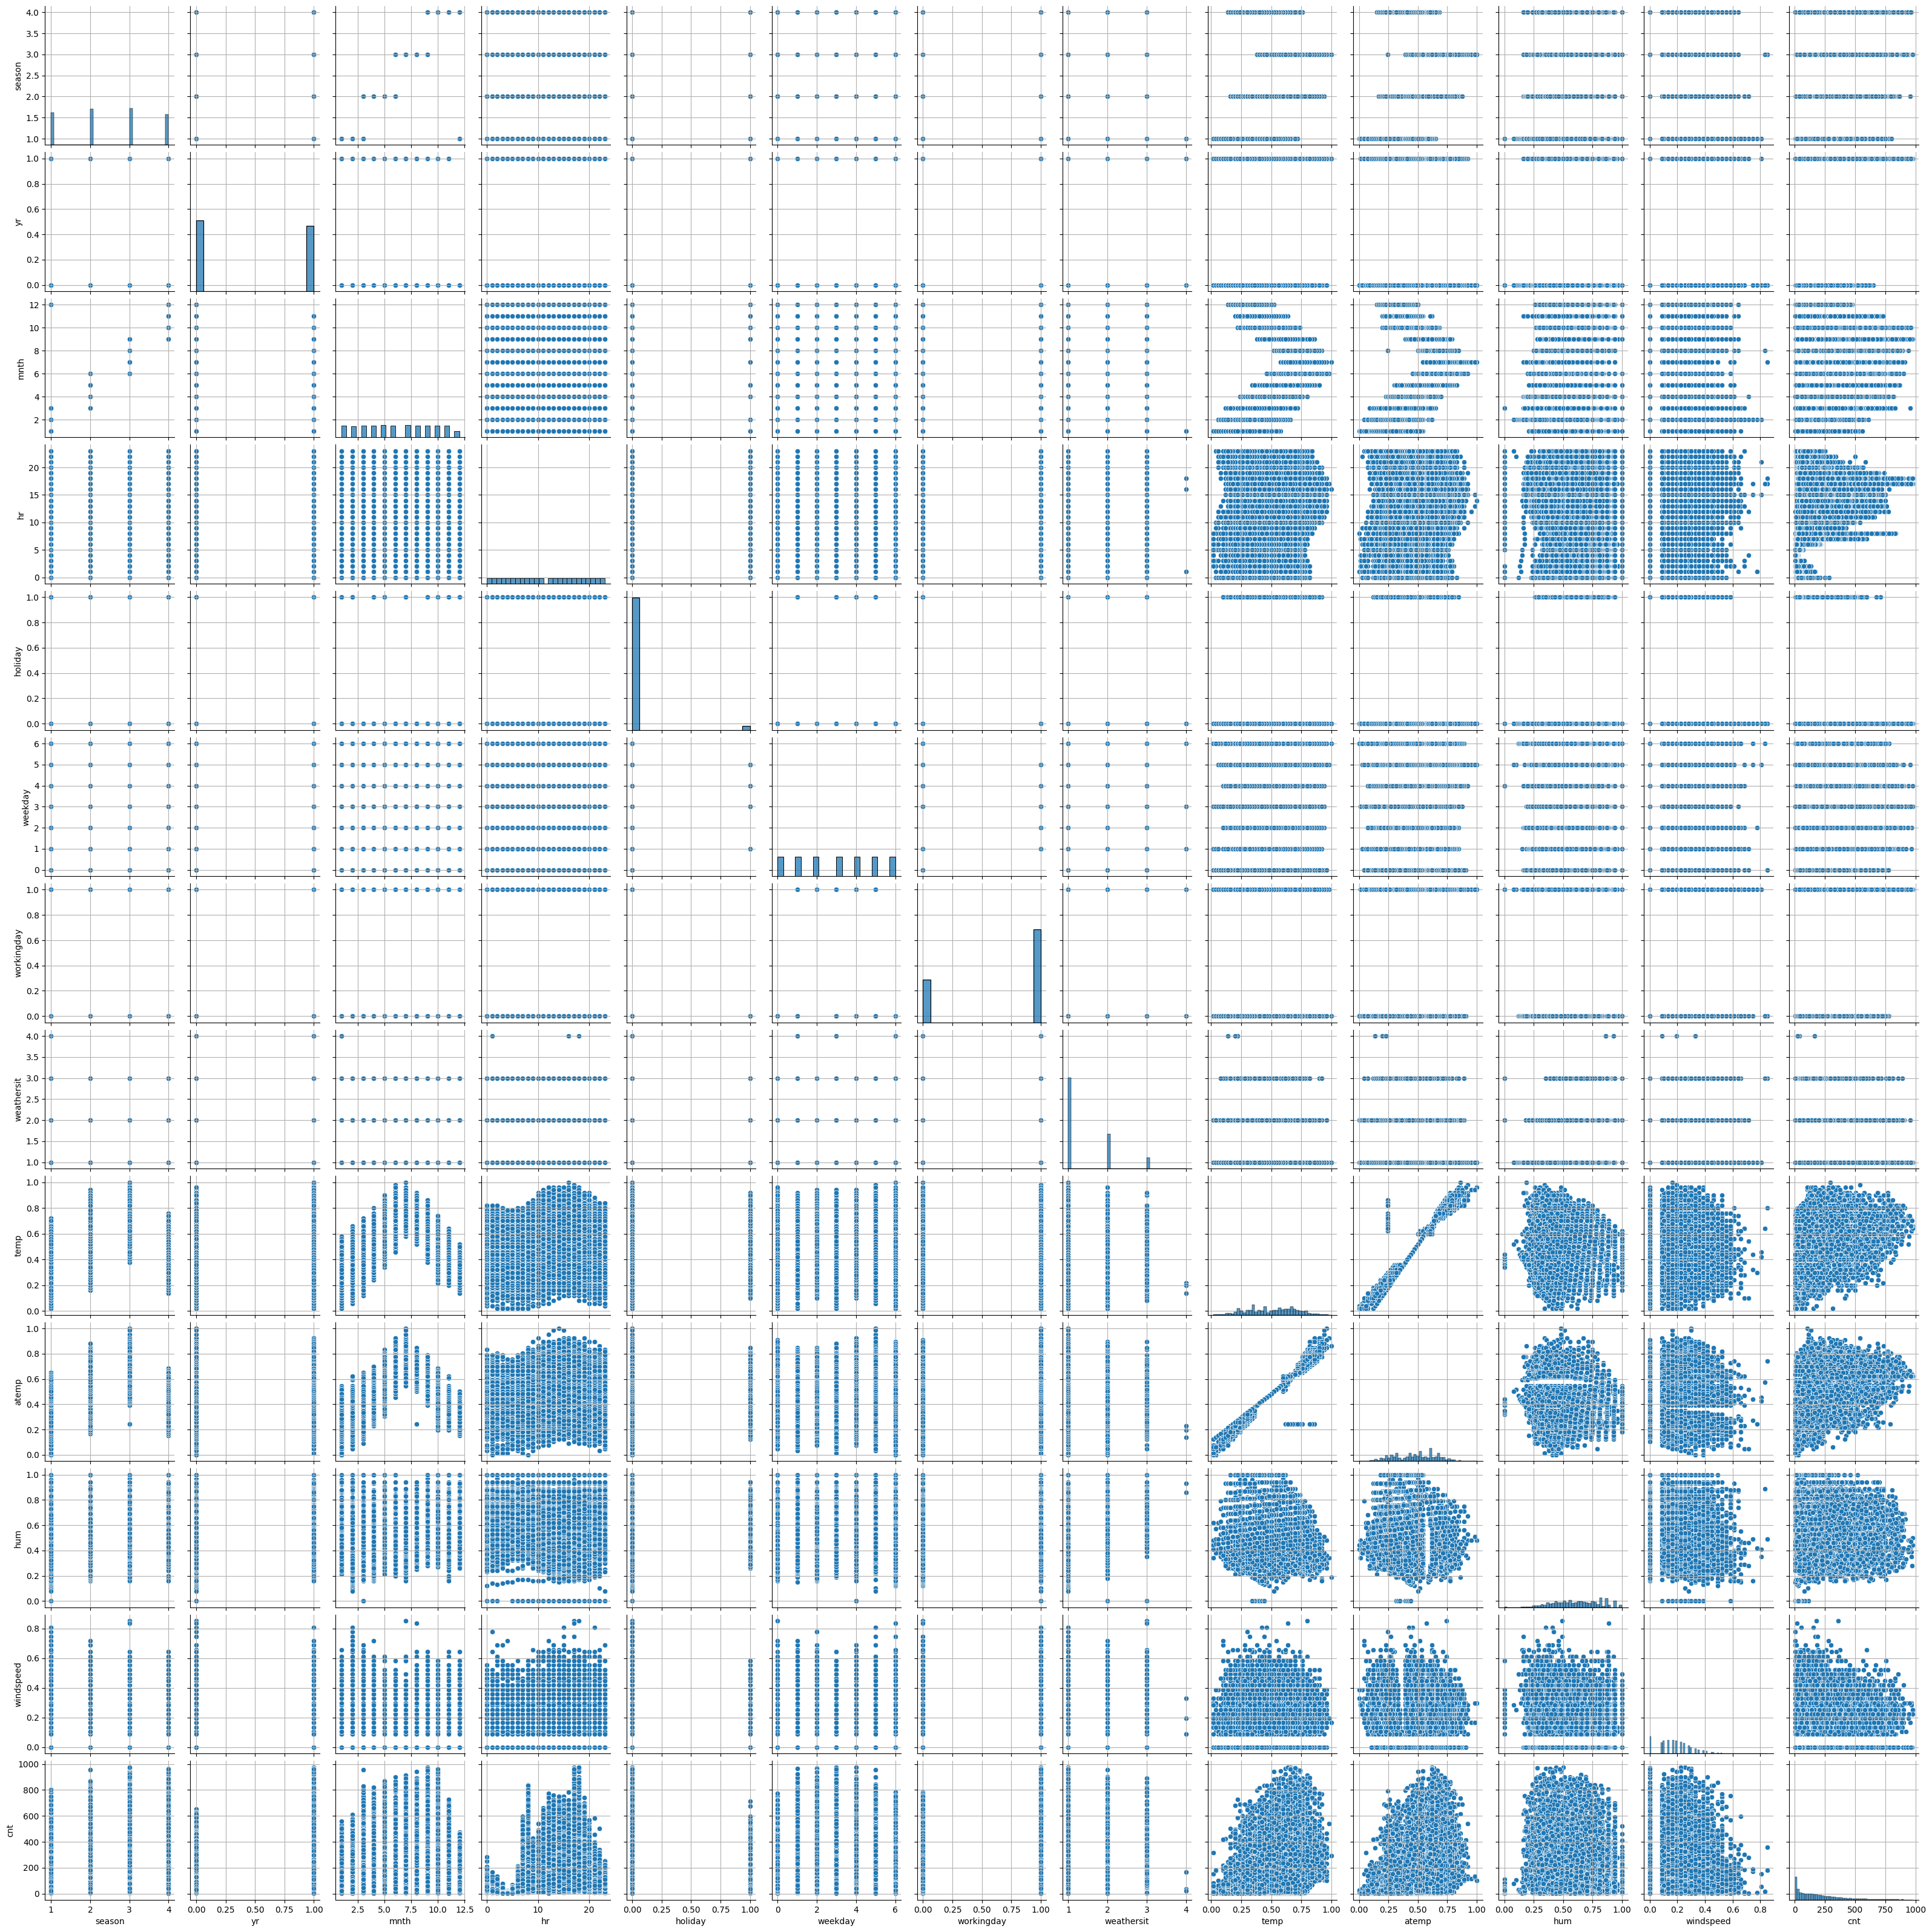

In [5]:
sns.pairplot(data1)

There are some correlations beetween features, let's see this better with a correlation matrix

<AxesSubplot: >

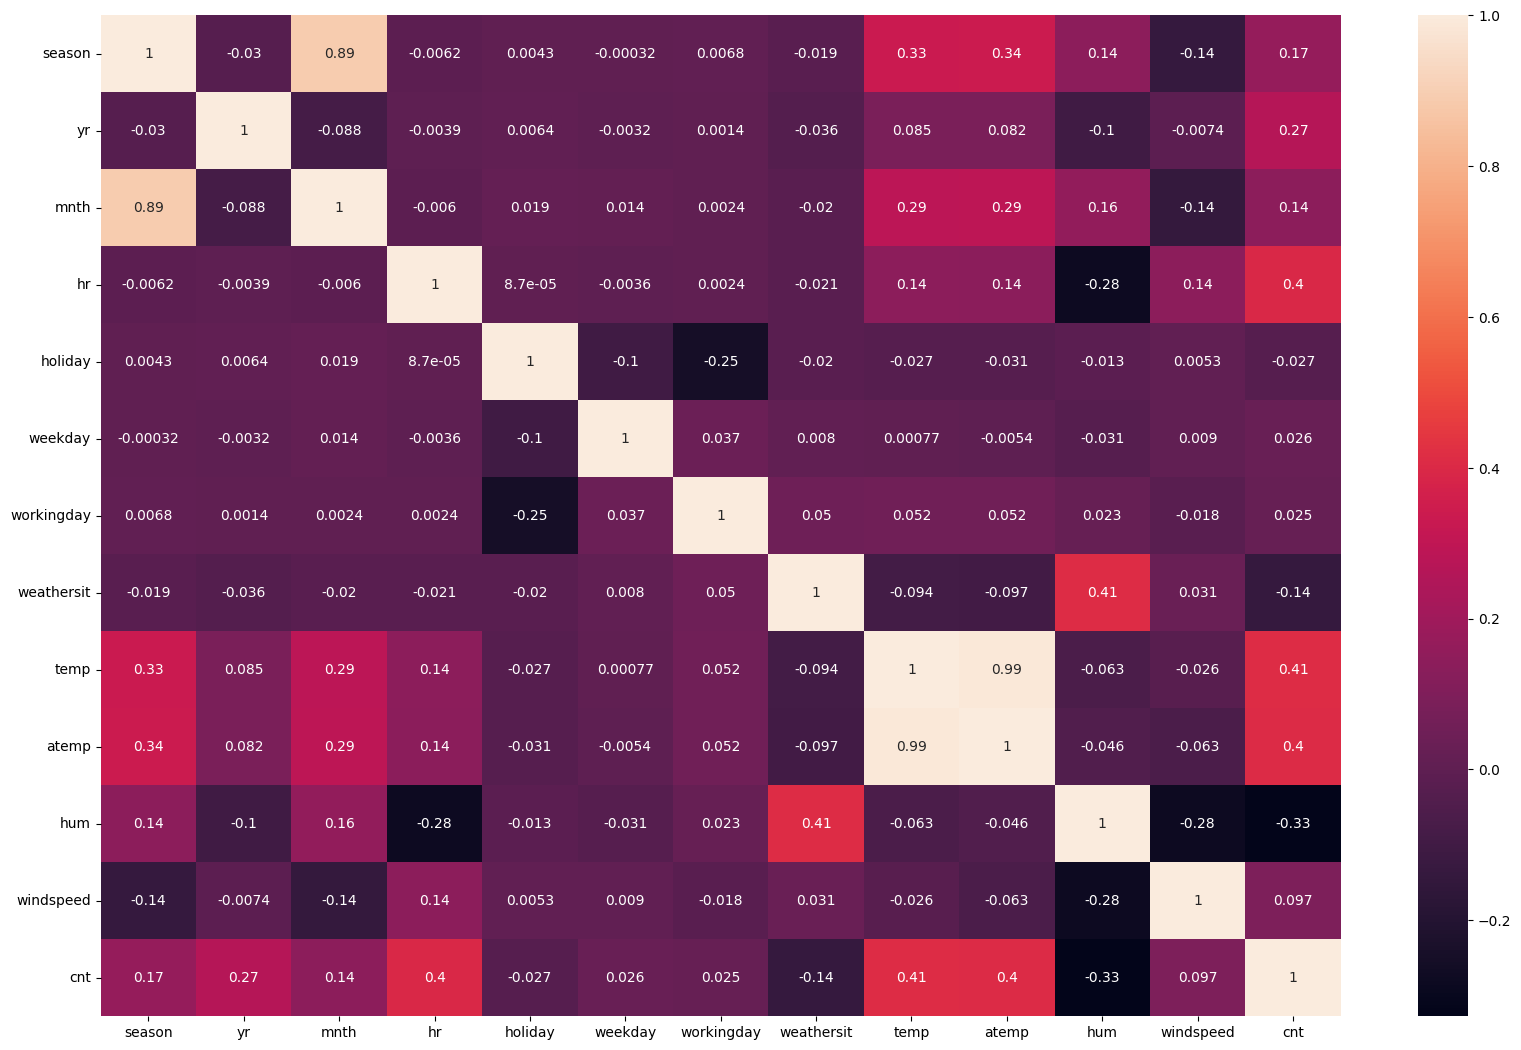

In [6]:
corr = data1.corr()
sns.heatmap(corr, annot=True)

Before dropping correlated features let's search for some insights

<AxesSubplot: xlabel='hr', ylabel='cnt'>

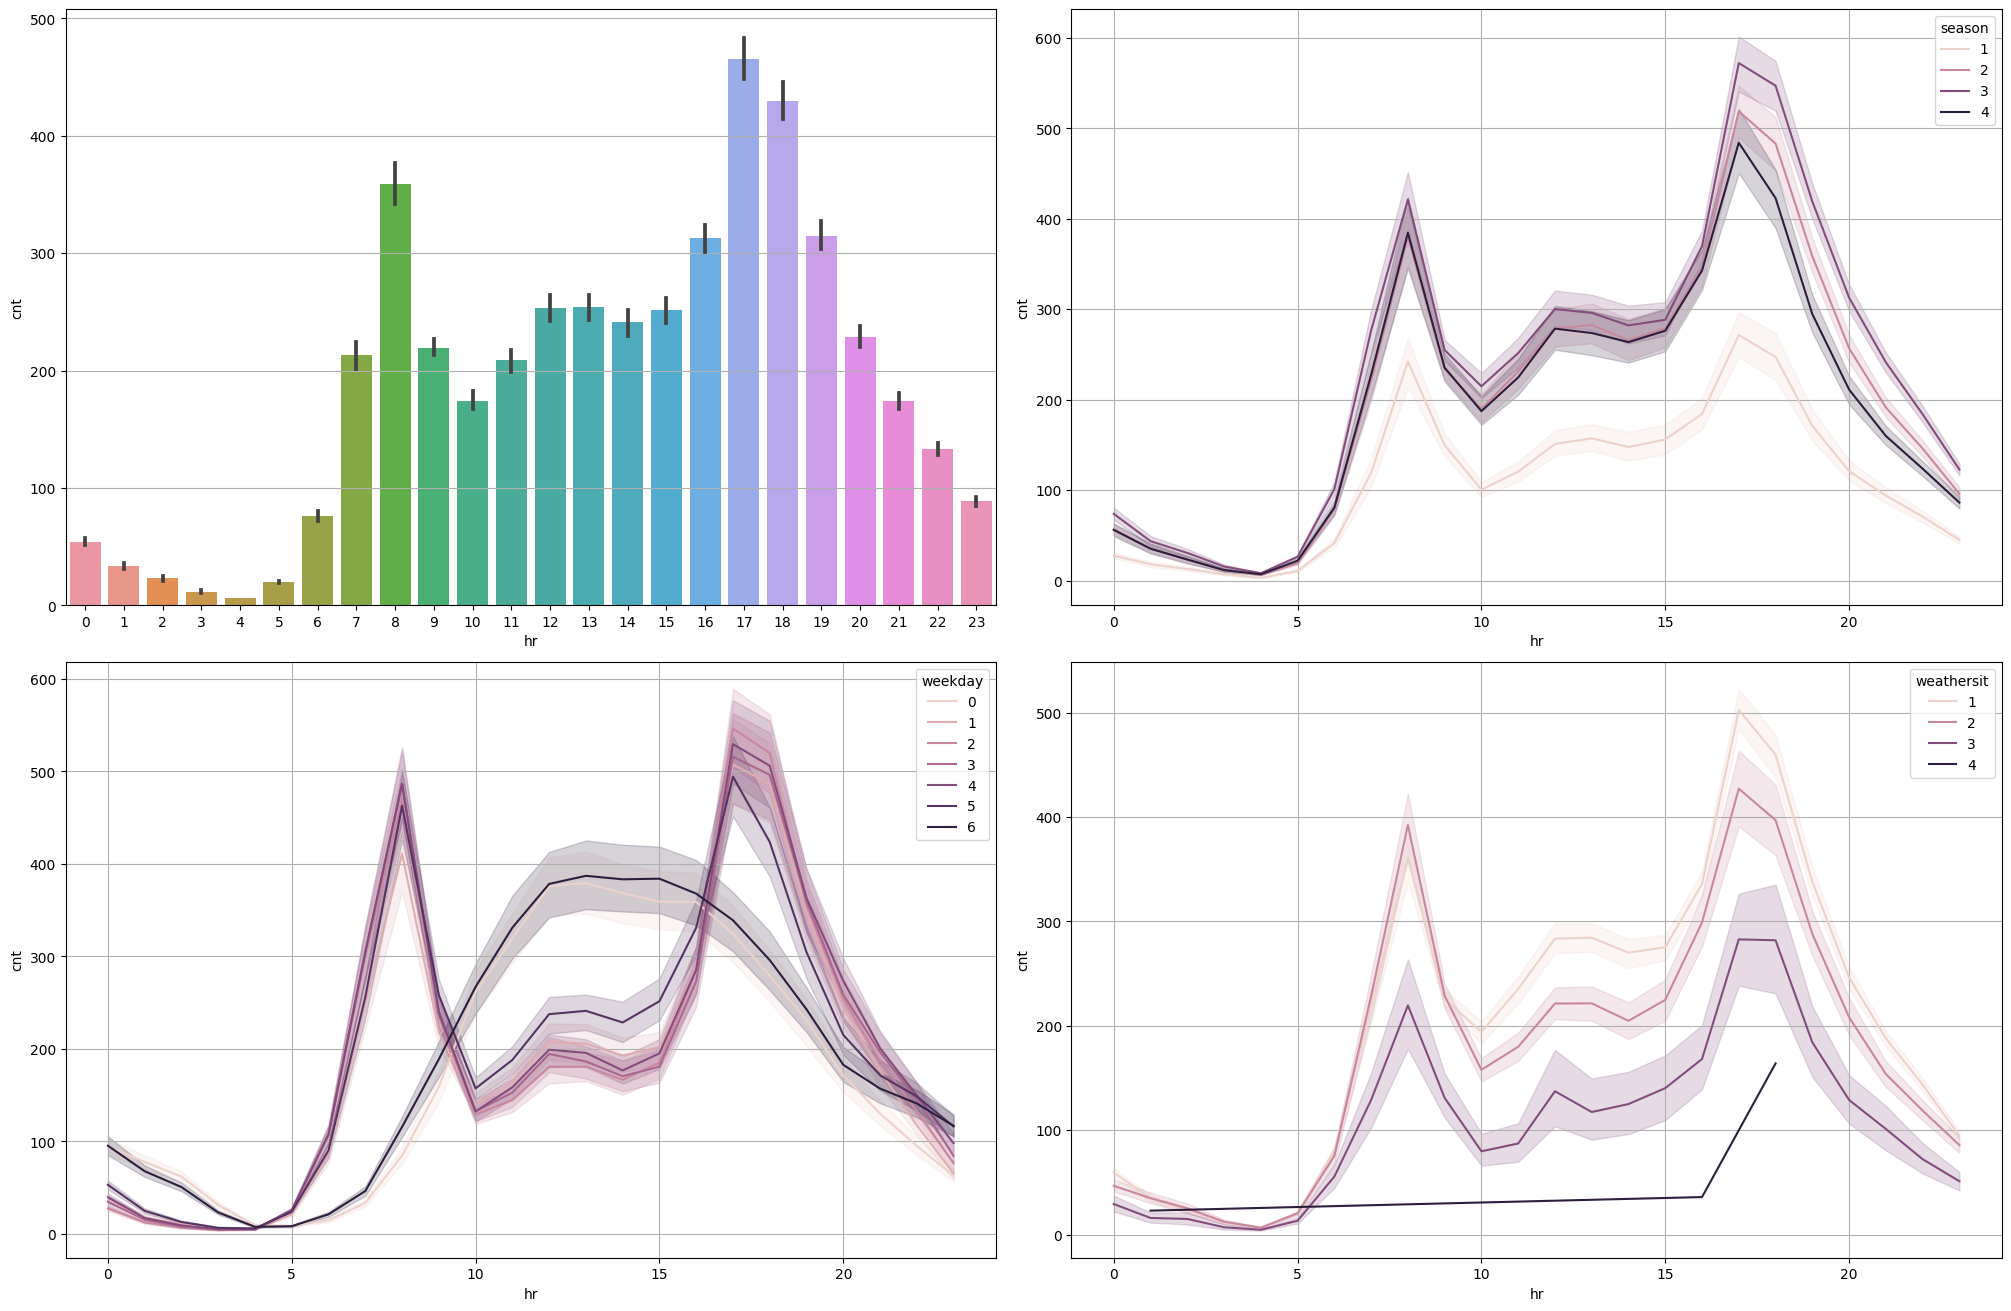

In [7]:
fig, axes = plt.subplots(2, 2, constrained_layout=True)
sns.barplot(data=data1, x='hr', y='cnt', ax = axes[0,0])
sns.lineplot(data=data1, x='hr', y='cnt', hue='season', ax = axes[0,1])
sns.lineplot(data=data1, x='hr', y='cnt', hue='weekday', ax = axes[1,0])
sns.lineplot(data=data1, x='hr', y='cnt', hue='weathersit', ax = axes[1,1])

As we can see during working days there are two peaks at 8:00 and 17:00/18:00 which are the tipical start/end of a working day.
<br>
Also during weekend the trend changes, we can see a peak from 12:00 to 15:00.
<br>
At the end as one could expect, there are less rents during colder seasons and when weather isn't good.

<AxesSubplot: xlabel='weathersit', ylabel='cnt'>

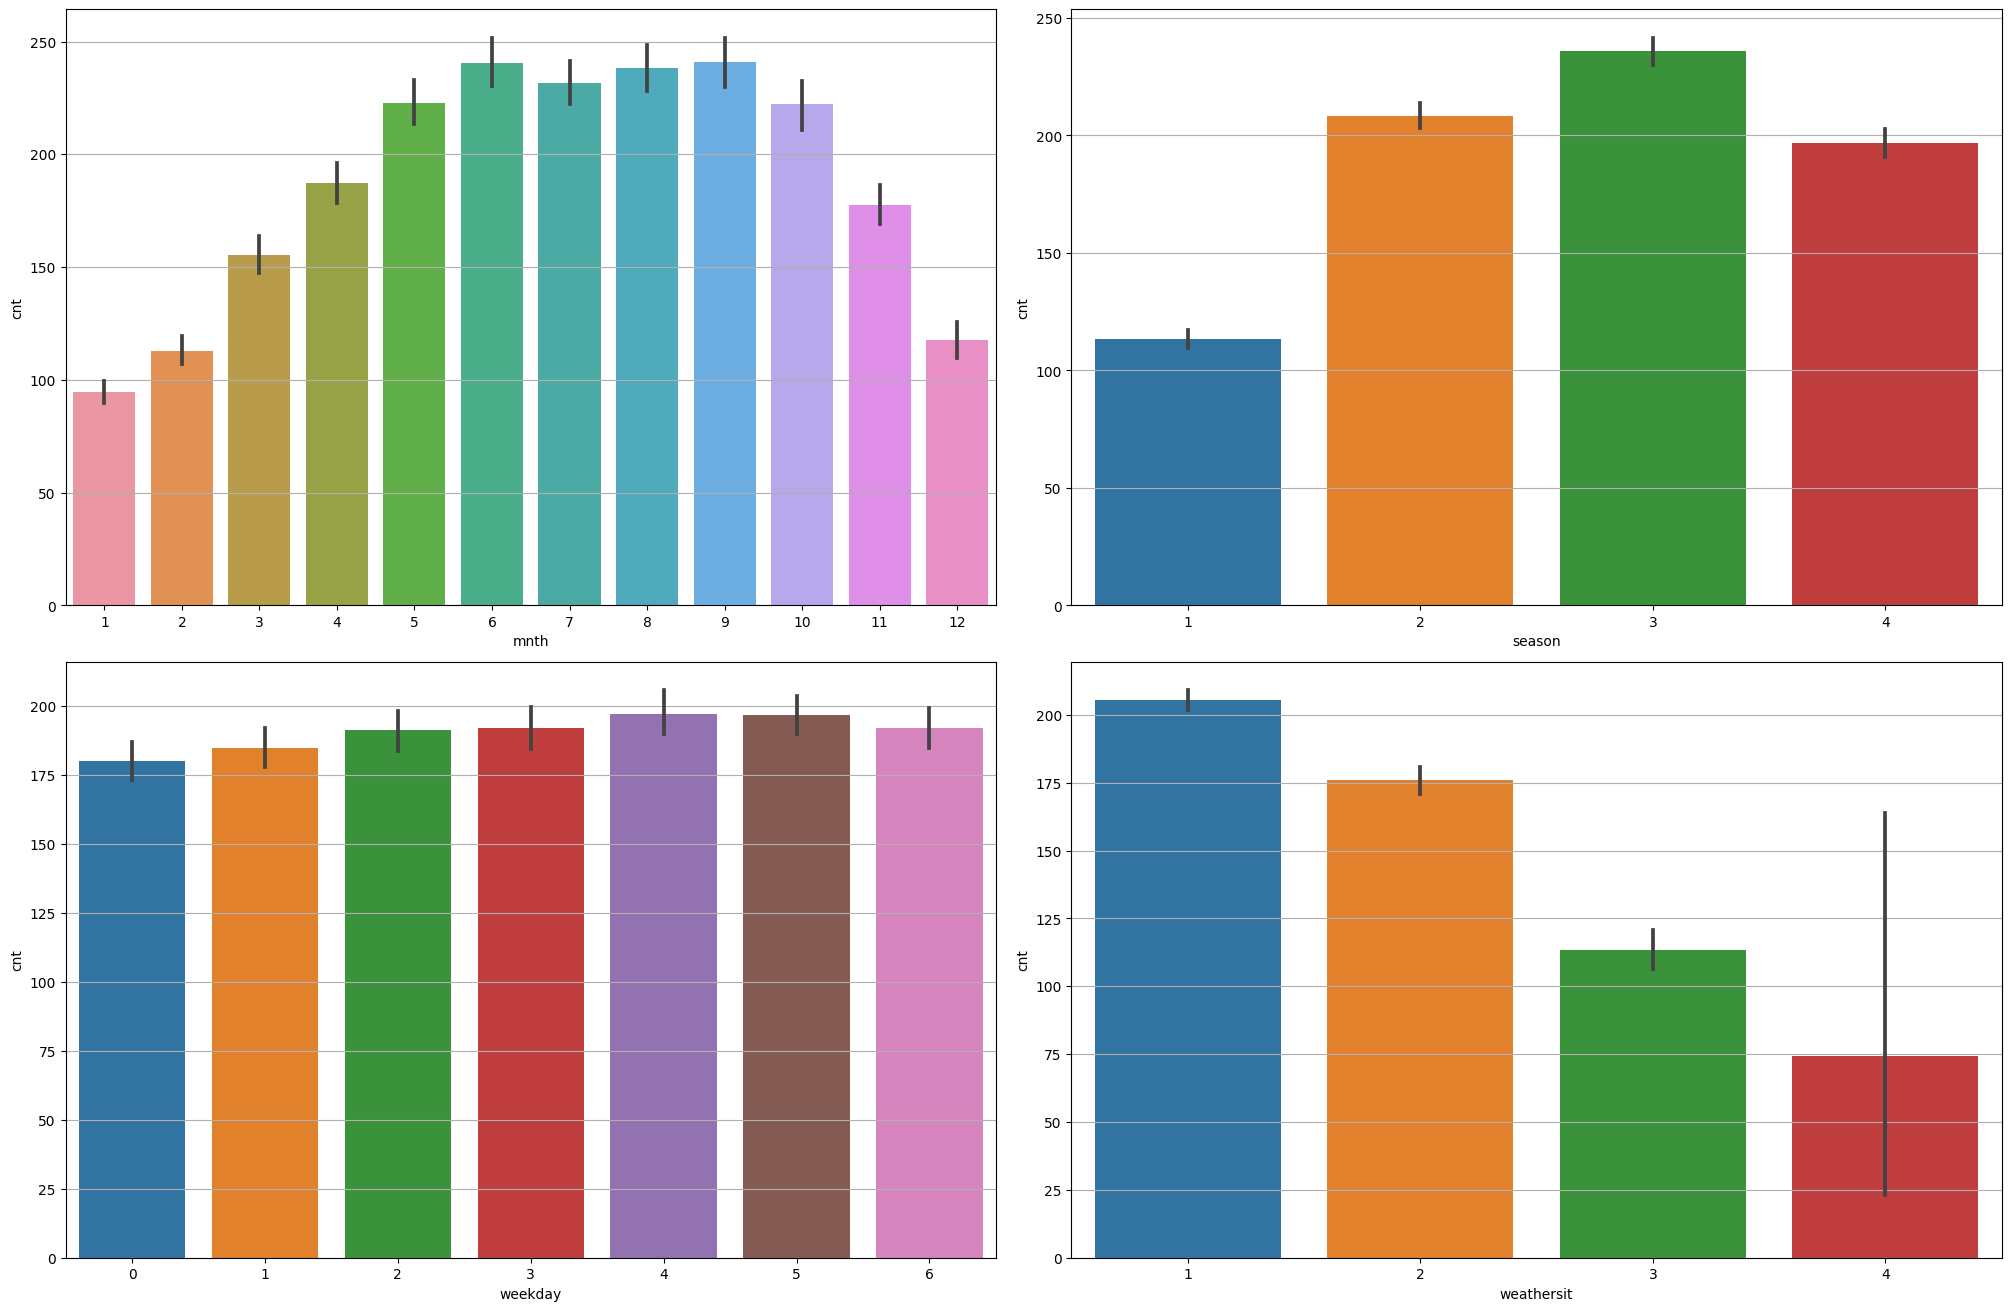

In [8]:
fig, axes = plt.subplots(2, 2, constrained_layout=True)
sns.barplot(data=data1, x='mnth', y='cnt', ax = axes[0,0])
sns.barplot(data=data1, x='season', y='cnt', ax = axes[0,1])
sns.barplot(data=data1, x='weekday', y='cnt', ax = axes[1,0])
sns.barplot(data=data1, x='weathersit', y='cnt', ax = axes[1,1])

In these graphs we can see the same trend on count vs month, there are higher counts during hotter months.
<br>
Also the count distributed during weekdays is pretty constant.
<br>
The weather situation influences negatively the count

Now we can drop correlated features, such as season and atemp

<AxesSubplot: >

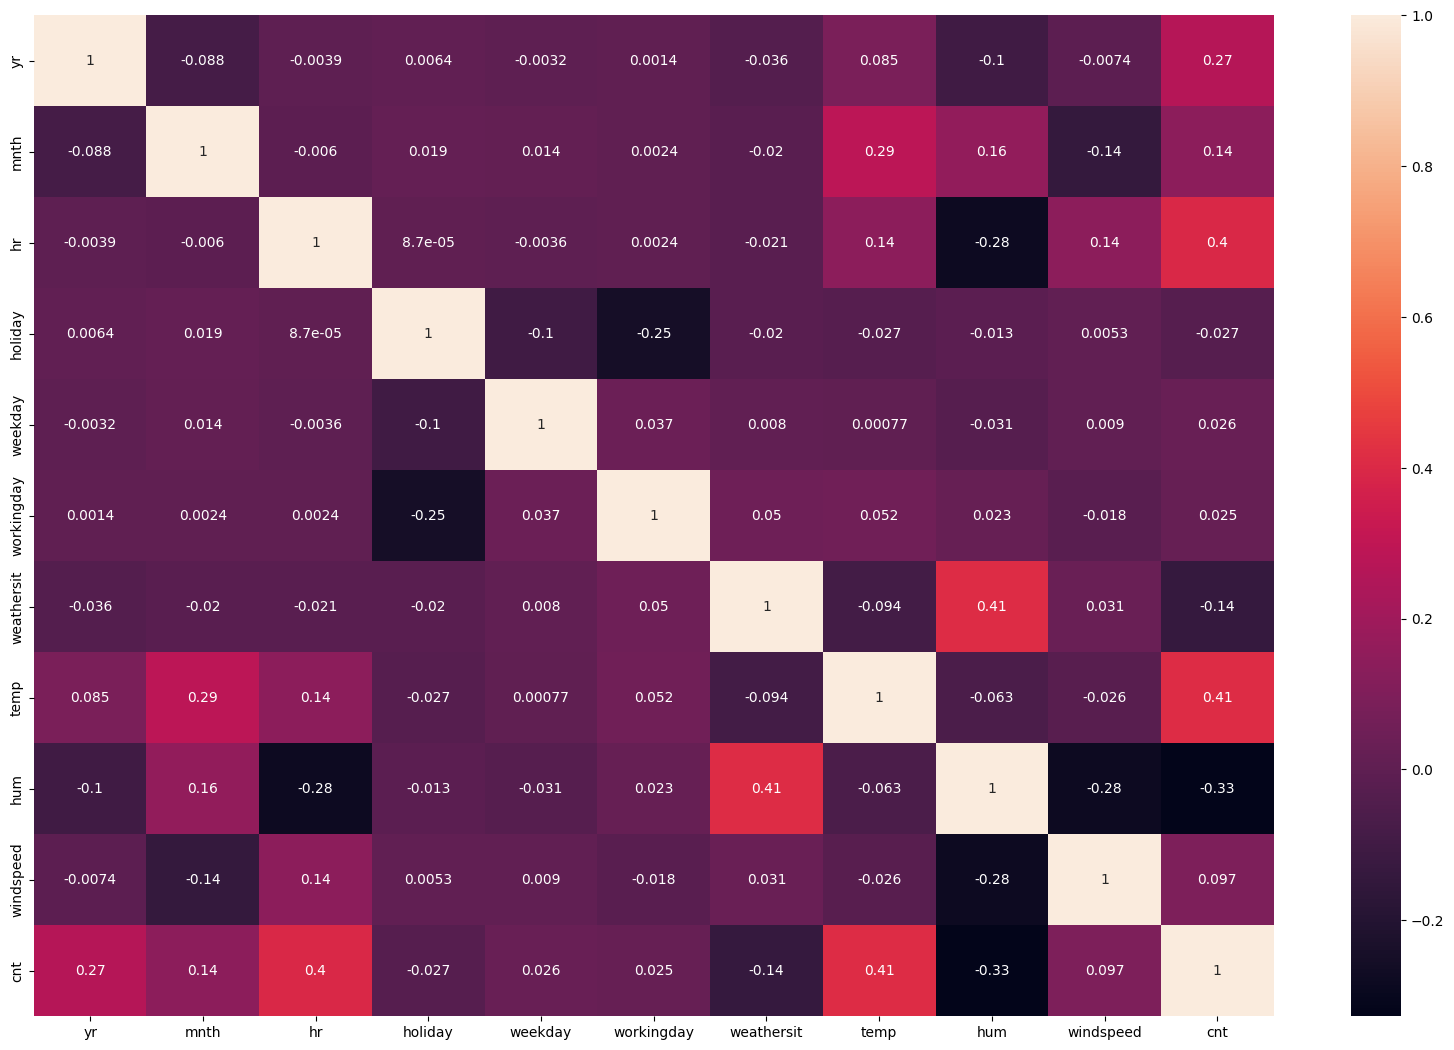

In [9]:
data2 = data1.drop(['atemp', 'season'], axis=1)
corr2 = data2.corr()
sns.heatmap(corr2, annot=True)

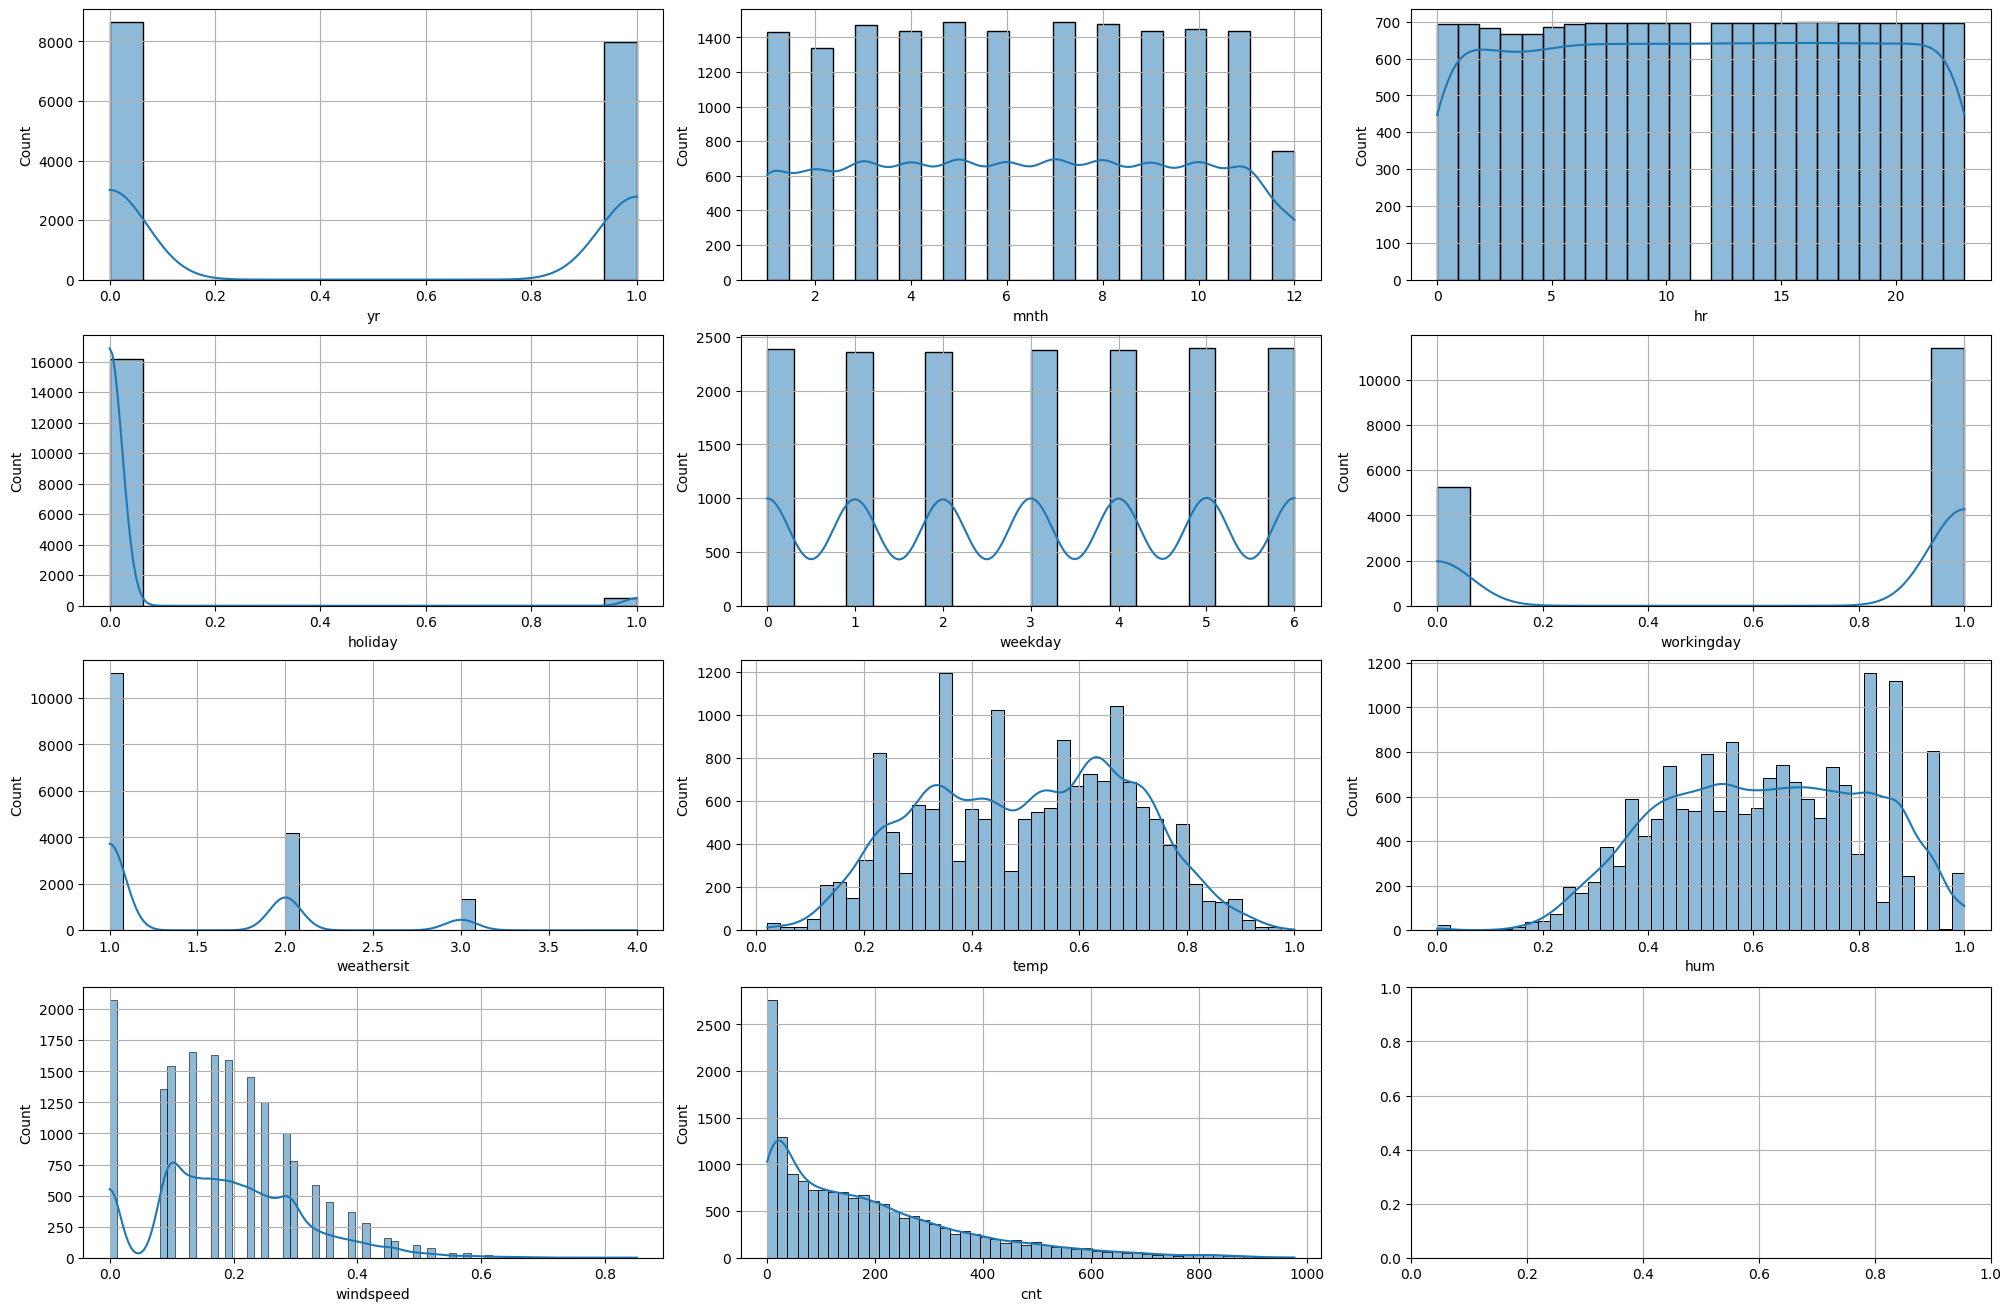

In [10]:
fig, axes = plt.subplots(4,3, constrained_layout = True)
for col, ax in zip(data2.columns, axes.flatten()):
    sns.histplot(data=data2, x=col, ax=ax, kde = True )

# Model Selection
## Non time series model

Features are already scaled, just to be precise lets'apply a MinMaxScaler on categorical features.
<br>
Let's try to evaluate a baseline Random Forest and an XGB Regressor, assuming features are not correlated with the previous hours.
<br>
We will evaluate the model with MAE and MAPE

In [11]:
transformer = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), [1,2,4,6])],
                                remainder='passthrough')

cols = data2.columns
idx = data2.index
data2 = pd.DataFrame(transformer.fit_transform(data2), idx, cols)

X_train = data2.values[:-720,:-1]
X_test = data2.values[-720:,:-1]
y_train = data2.values[:-720,-1]
y_test = data2.values[-720:,-1]

<module 'matplotlib.pyplot' from 'C:\\Users\\ggiam\\anaconda3\\envs\\py10\\lib\\site-packages\\matplotlib\\pyplot.py'>

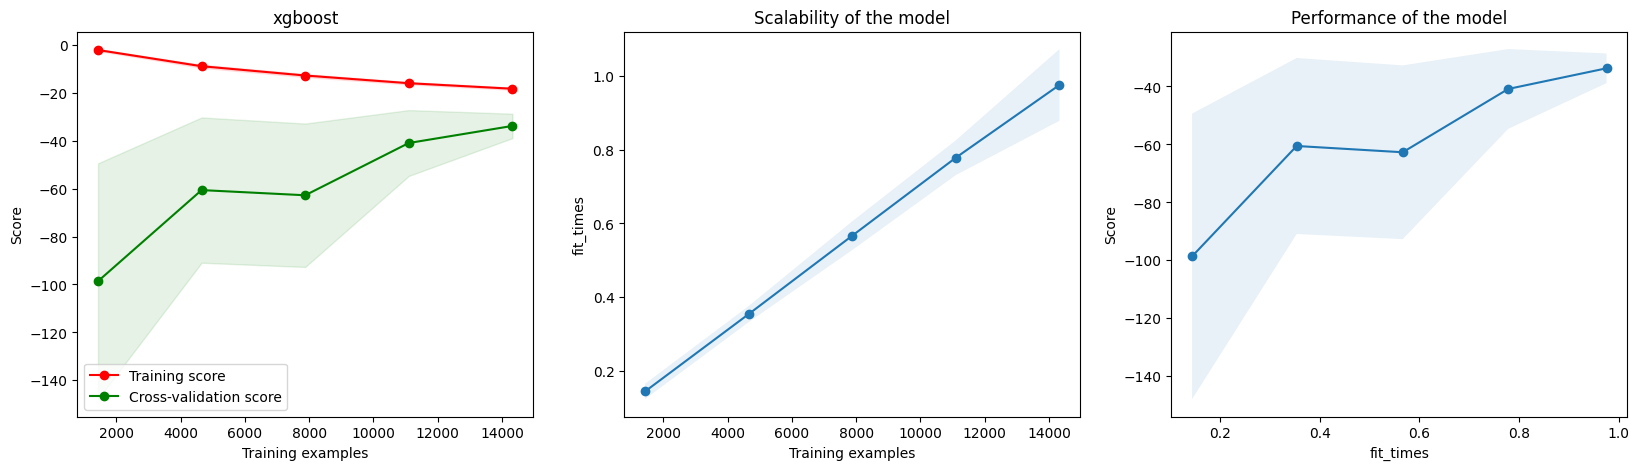

In [12]:
xgb = XGBRegressor()
plot_learning_curve(xgb,'xgboost', X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')

The model is not overfitting that much

Train MAE: 18.681604860619757 | Test MAE: 44.953804314509036
Train MAPE: 0.2754584183814119 | Test MAPE: 0.5540312043728749
Train mean: 189.48520449833512 | Test mean: 212.40277777777777


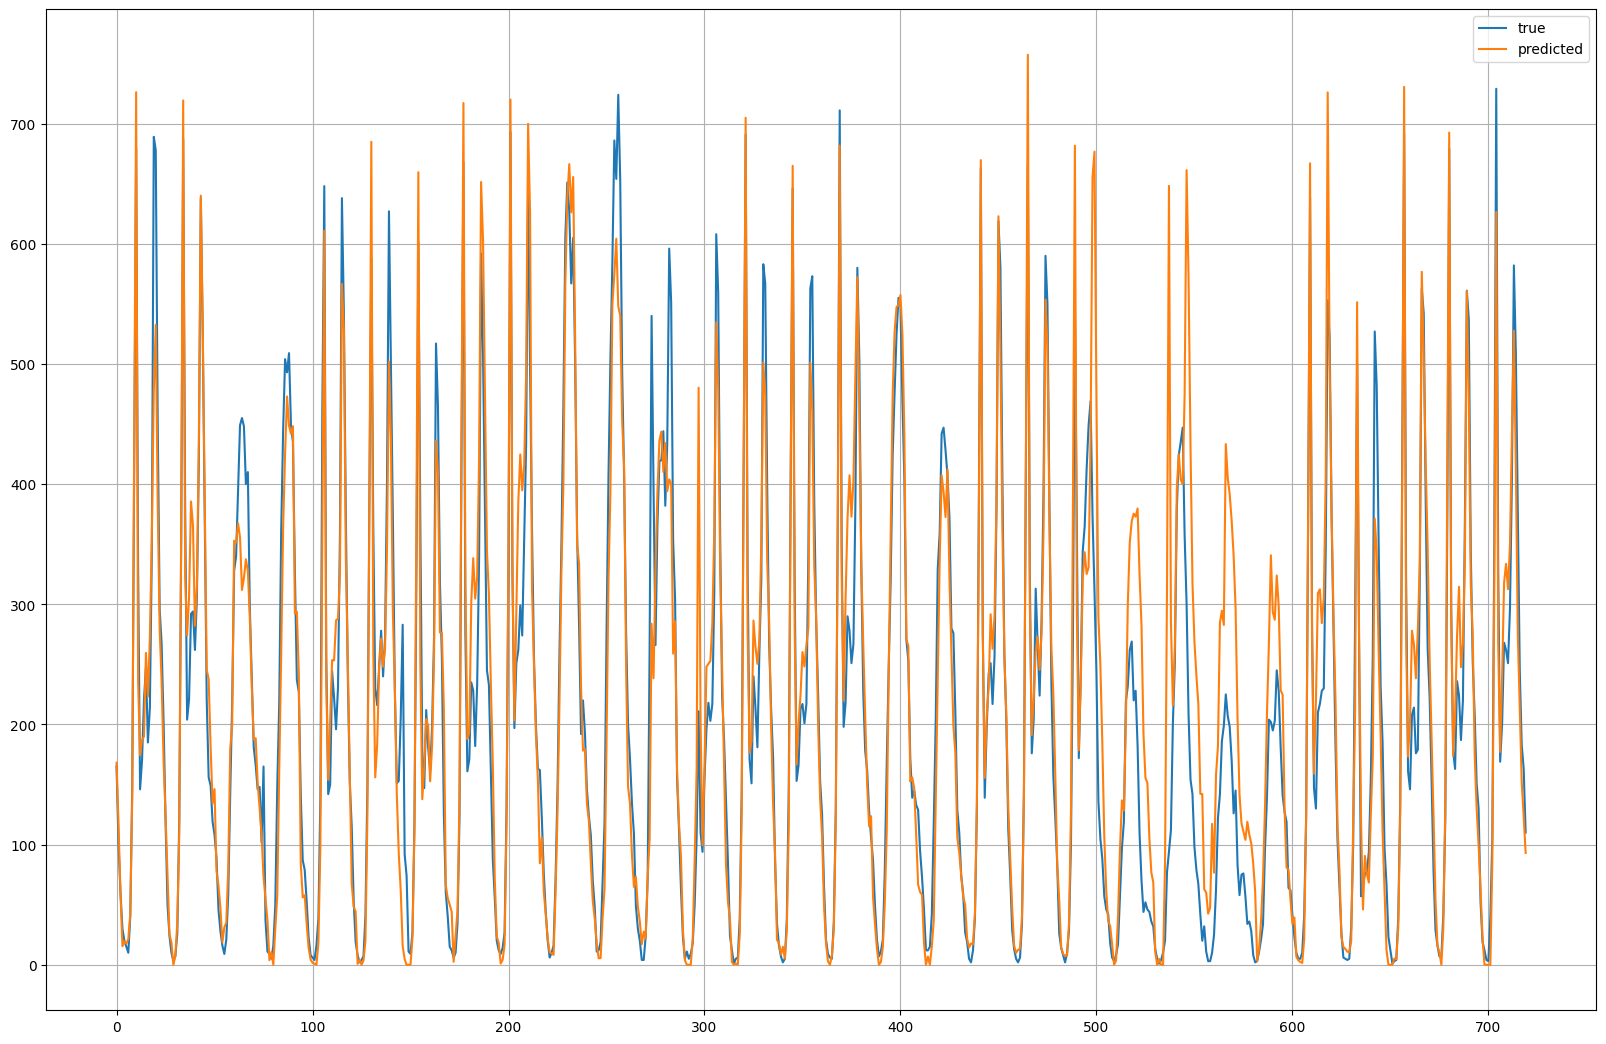

In [13]:
xgb.fit(X_train, y_train)

train_pred = xgb.predict(X_train)
test_pred = xgb.predict(X_test)

#Let's set negative values to 0
train_pred = np.where(train_pred < 0, 0, train_pred)
test_pred = np.where(test_pred < 0, 0, test_pred)

sns.lineplot(y_test, label='true')
sns.lineplot(test_pred, label='predicted')

print(f'Train MAE: {mean_absolute_error(y_train, train_pred)} | Test MAE: {mean_absolute_error(y_test, test_pred)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_pred)} | Test MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
print(f'Train mean: {y_train.mean()} | Test mean: {y_test.mean()}')

While the MAE seems to be good, the MAPE shows a 57% error, let's try to obtain better results

-10.815439408645034 70.25585793234441


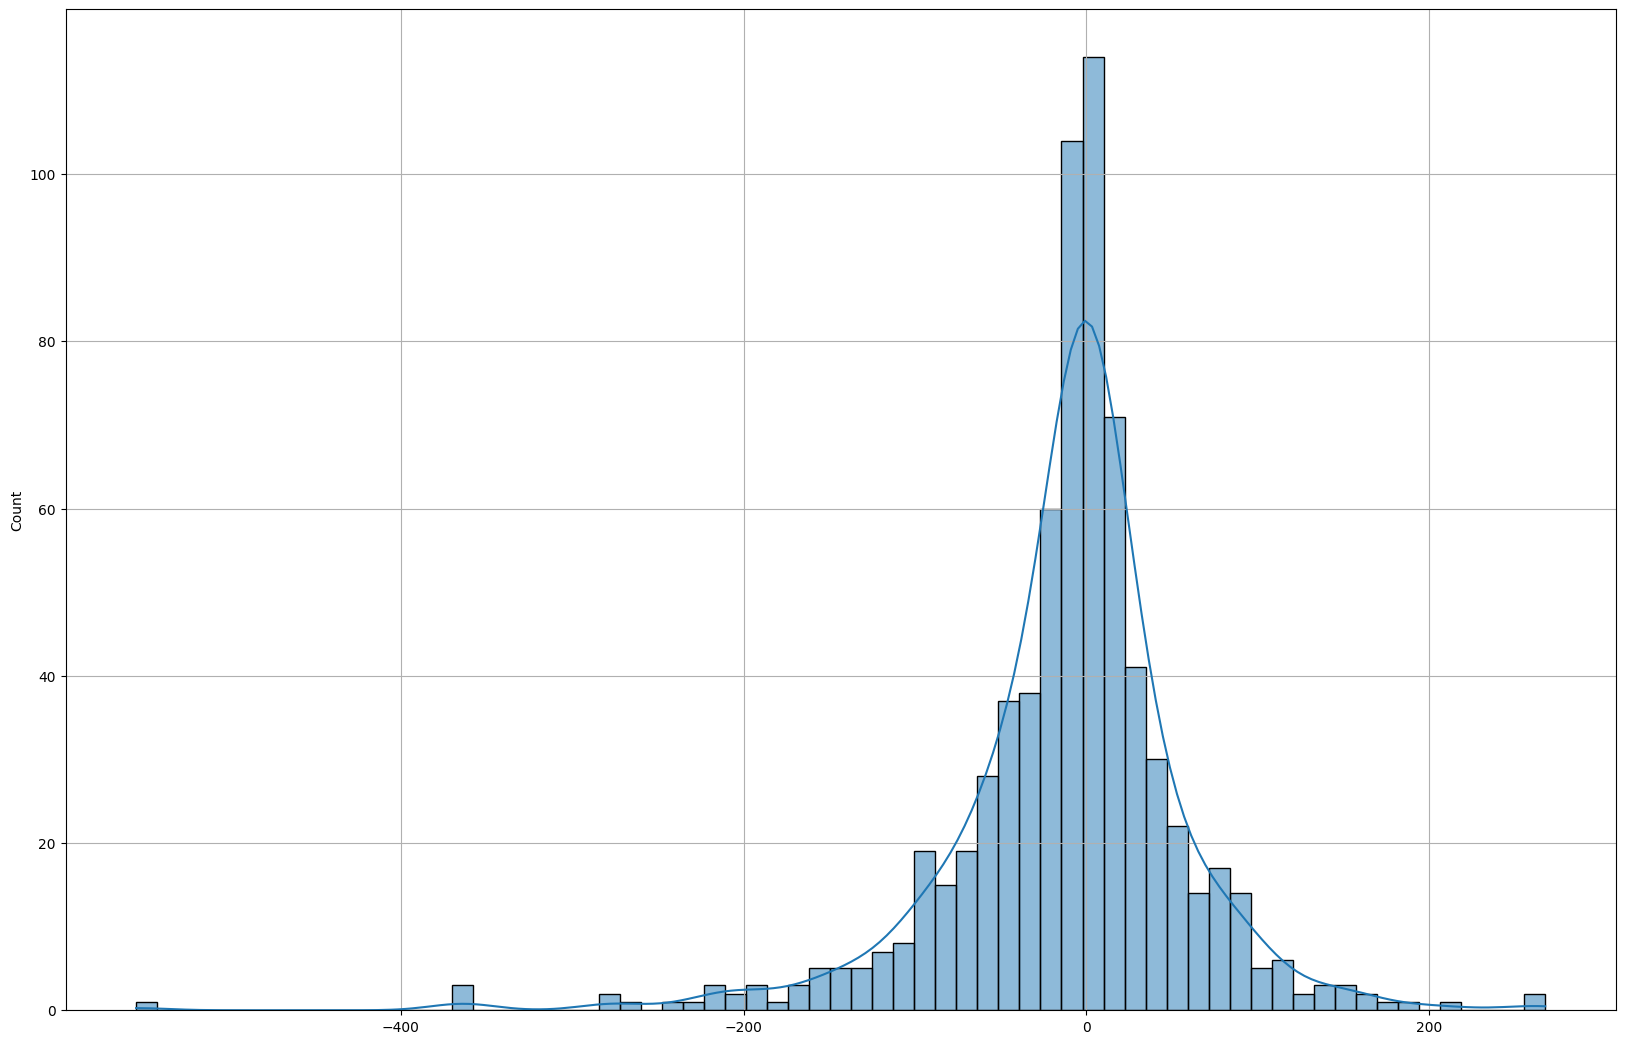

In [14]:
ae = y_test-test_pred
sns.histplot(ae, kde=True)
print(ae.mean(), ae.std())

From the distribution of residuals we can see that the model tends to overestimate the count of bycicle rented

<AxesSubplot: >

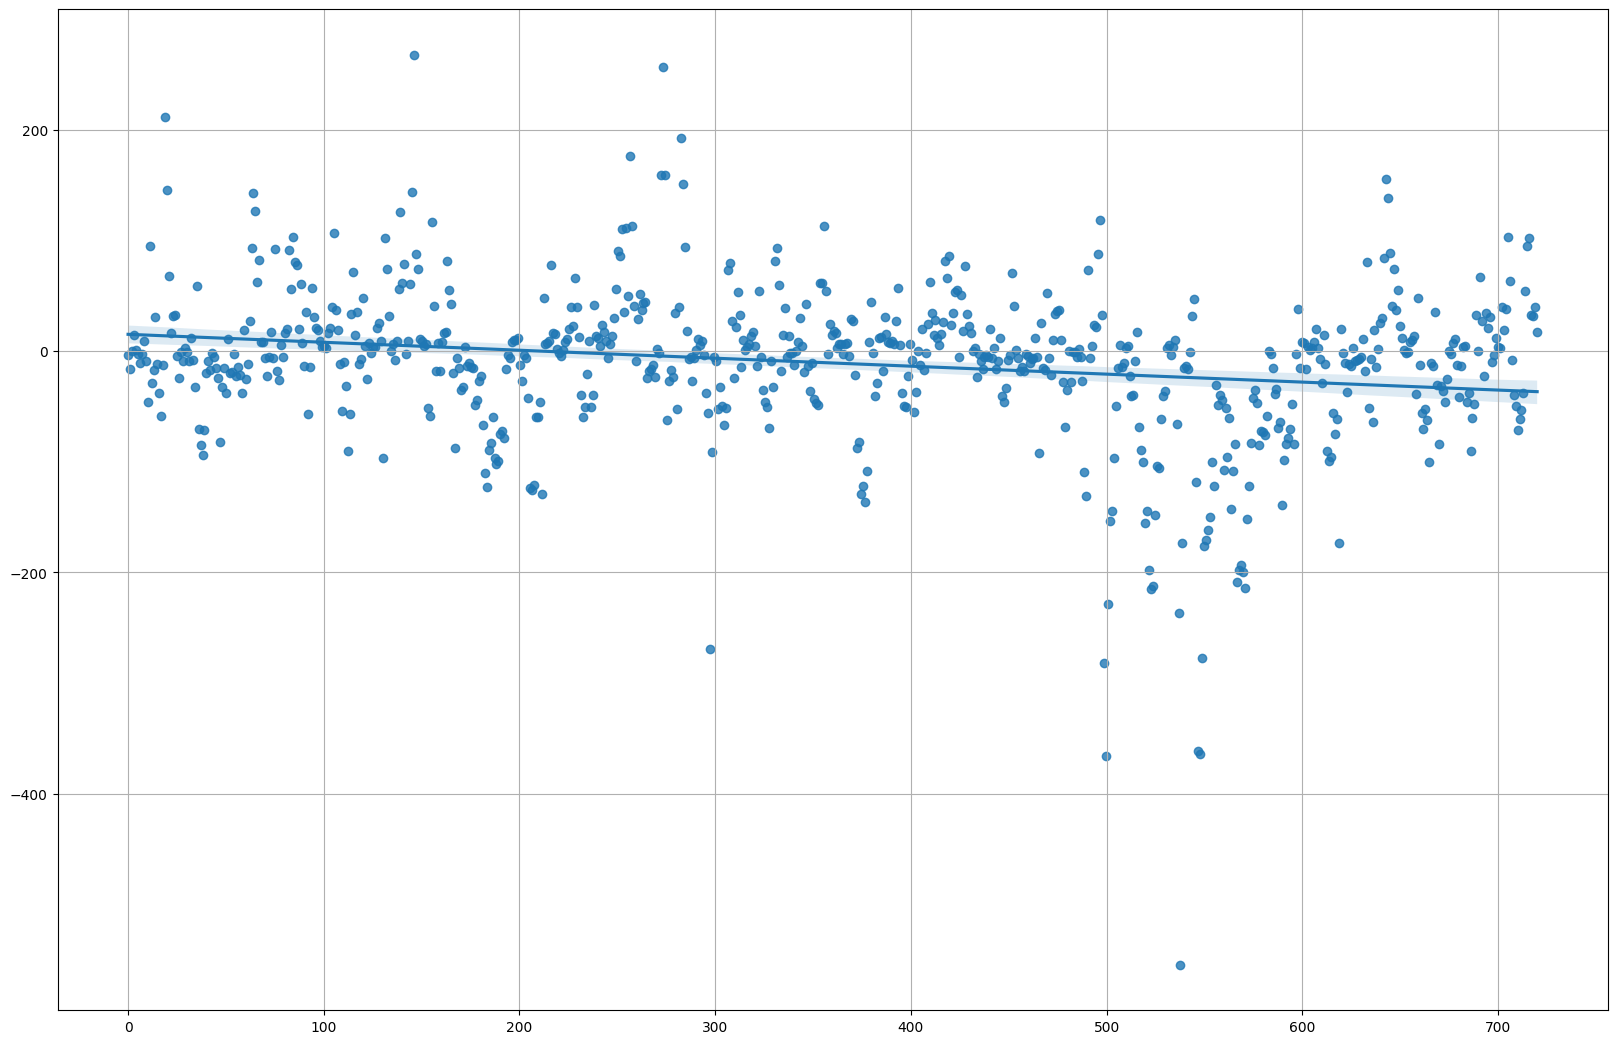

In [15]:
xax = np.linspace(0,ae.shape[0], ae.shape[0])
sns.regplot(x=xax, y=ae)

Additional information from the scatterplot of residuals is that there is an anomaly in the rent on the last 250 hours of test set 

<module 'matplotlib.pyplot' from 'C:\\Users\\ggiam\\anaconda3\\envs\\py10\\lib\\site-packages\\matplotlib\\pyplot.py'>

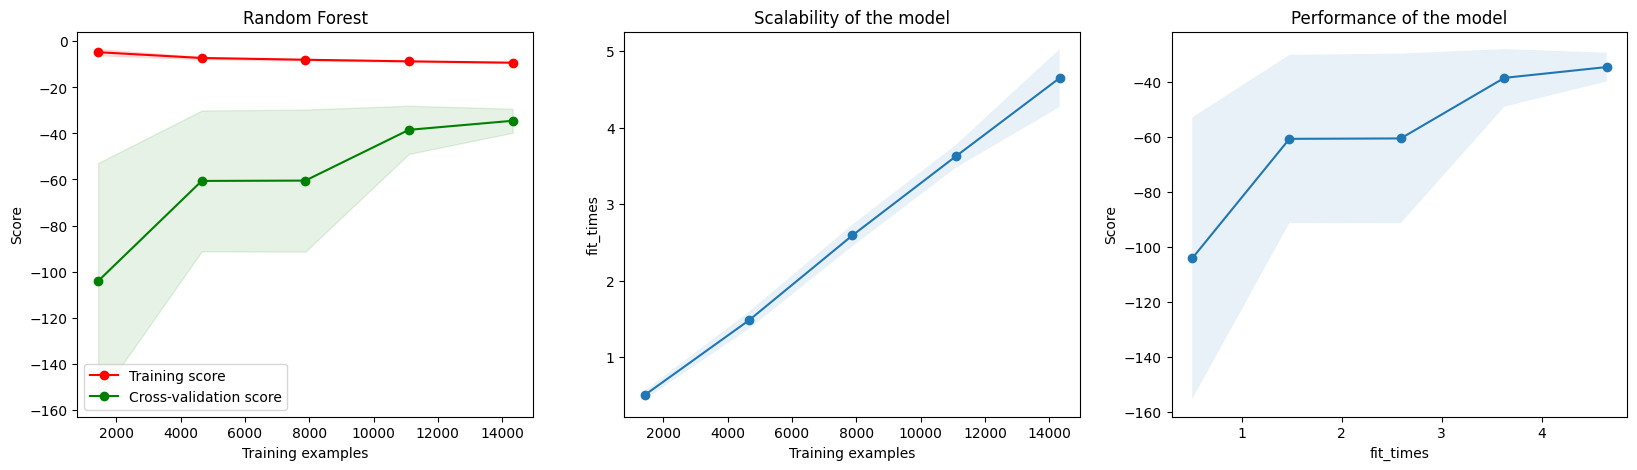

In [16]:
rf = RandomForestRegressor()
plot_learning_curve(rf,'Random Forest', X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')

Train MAE: 9.317691017689981 | Test MAE: 47.909756944444446
Train MAPE: 0.11224969474232575 | Test MAPE: 0.39050735685138205
Train mean: 189.48520449833512 | Test mean: 212.40277777777777


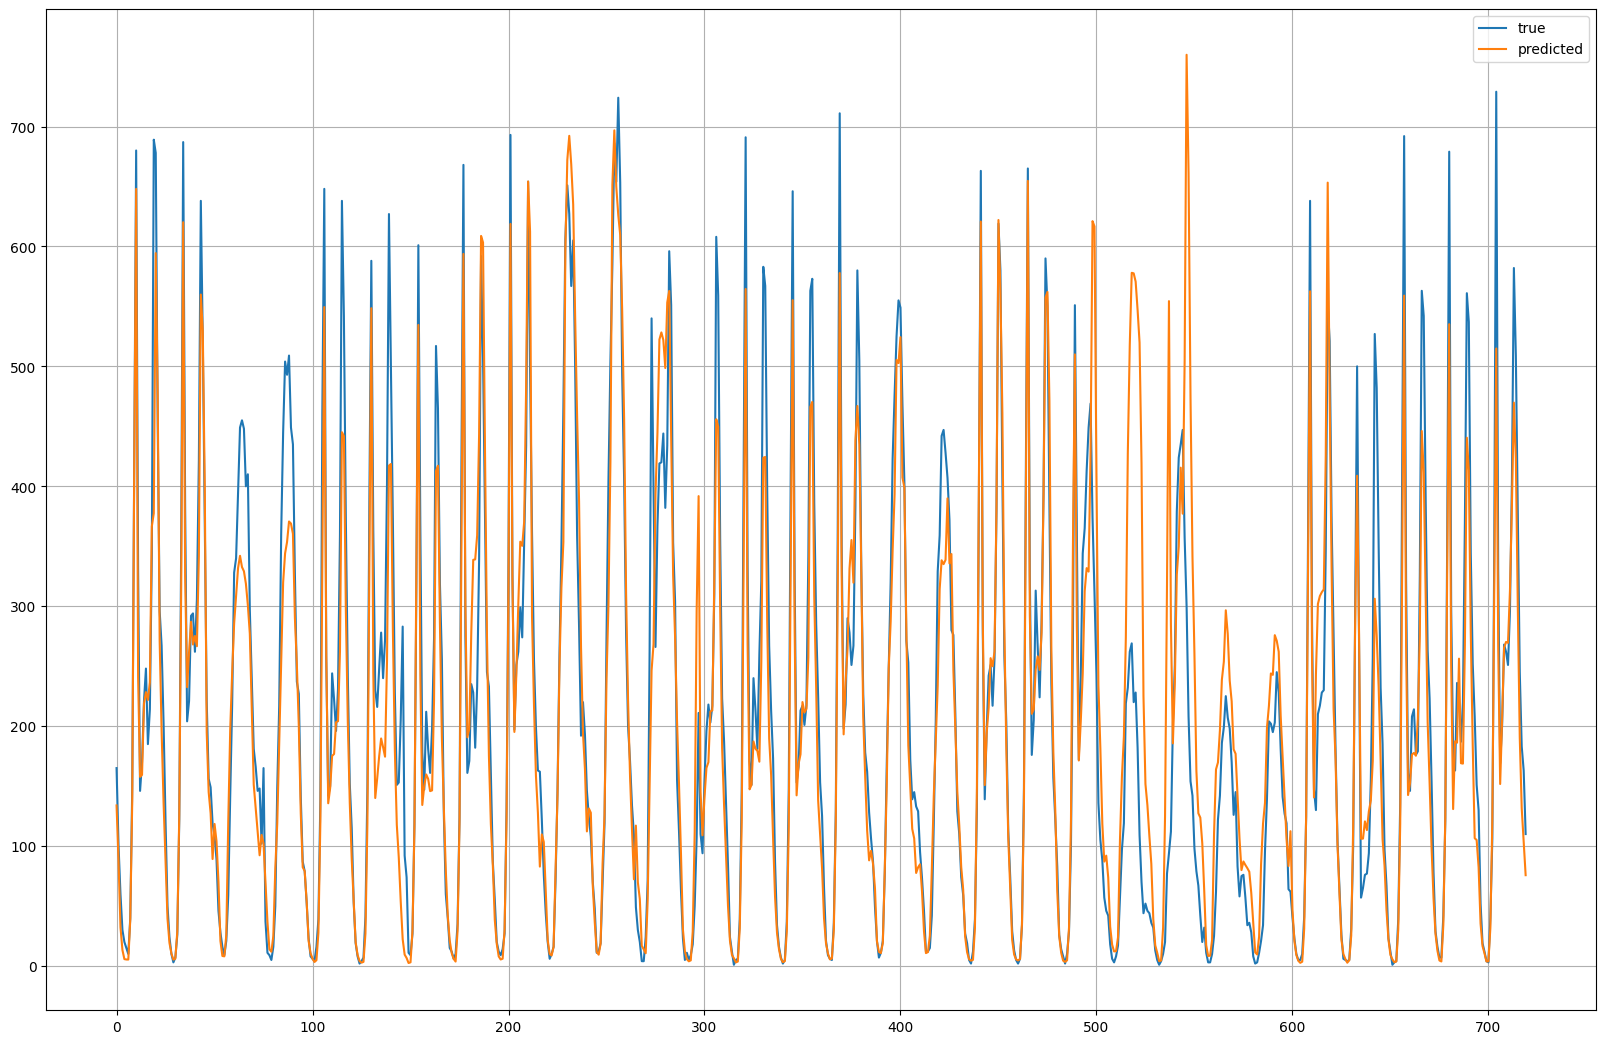

In [17]:
rf.fit(X_train, y_train)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

#Let's set negative values to 0
train_pred = np.where(train_pred < 0, 0, train_pred)
test_pred = np.where(test_pred < 0, 0, test_pred)

sns.lineplot(y_test, label='true')
sns.lineplot(test_pred, label='predicted')

print(f'Train MAE: {mean_absolute_error(y_train, train_pred)} | Test MAE: {mean_absolute_error(y_test, test_pred)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_pred)} | Test MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
print(f'Train mean: {y_train.mean()} | Test mean: {y_test.mean()}')

Random Forest is clearly overfitting but shows more accurate results if we consider the MAPE.
<br>
After we'll try a Grid Search of the models to see if it reduce overfits and achieve better results

4.806831018518519 78.3659521677309


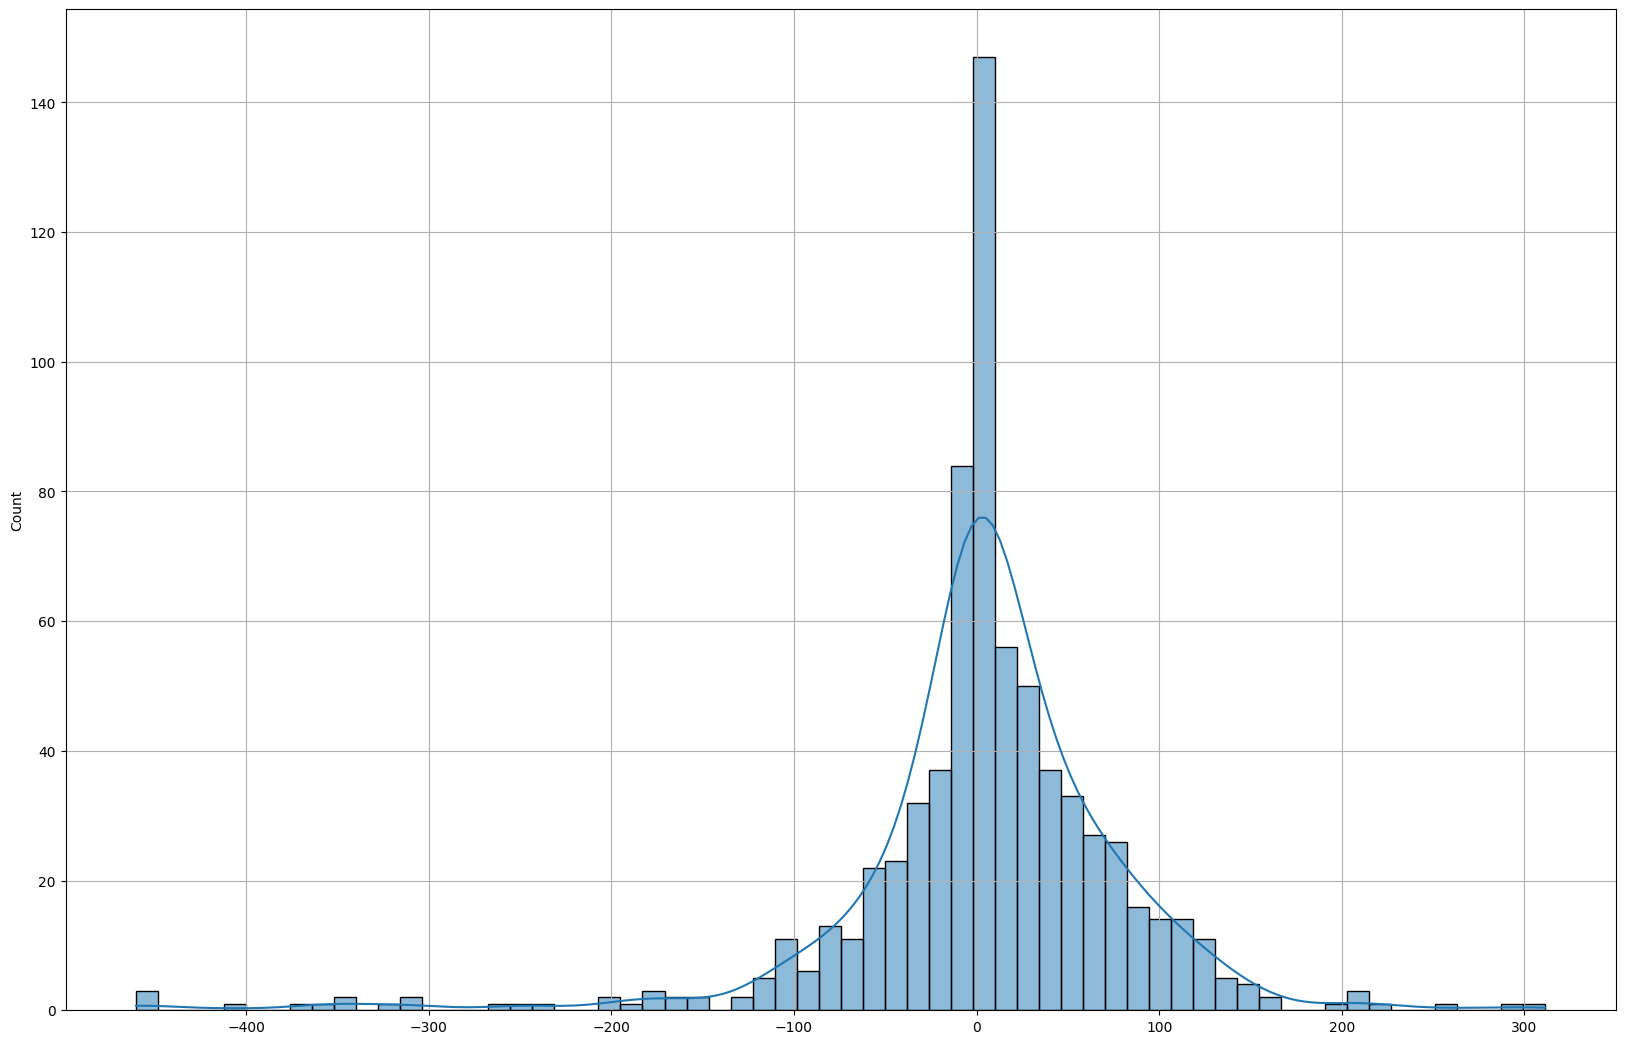

In [18]:
ae = y_test-test_pred
sns.histplot(ae, kde=True)
print(ae.mean(), ae.std())

<AxesSubplot: >

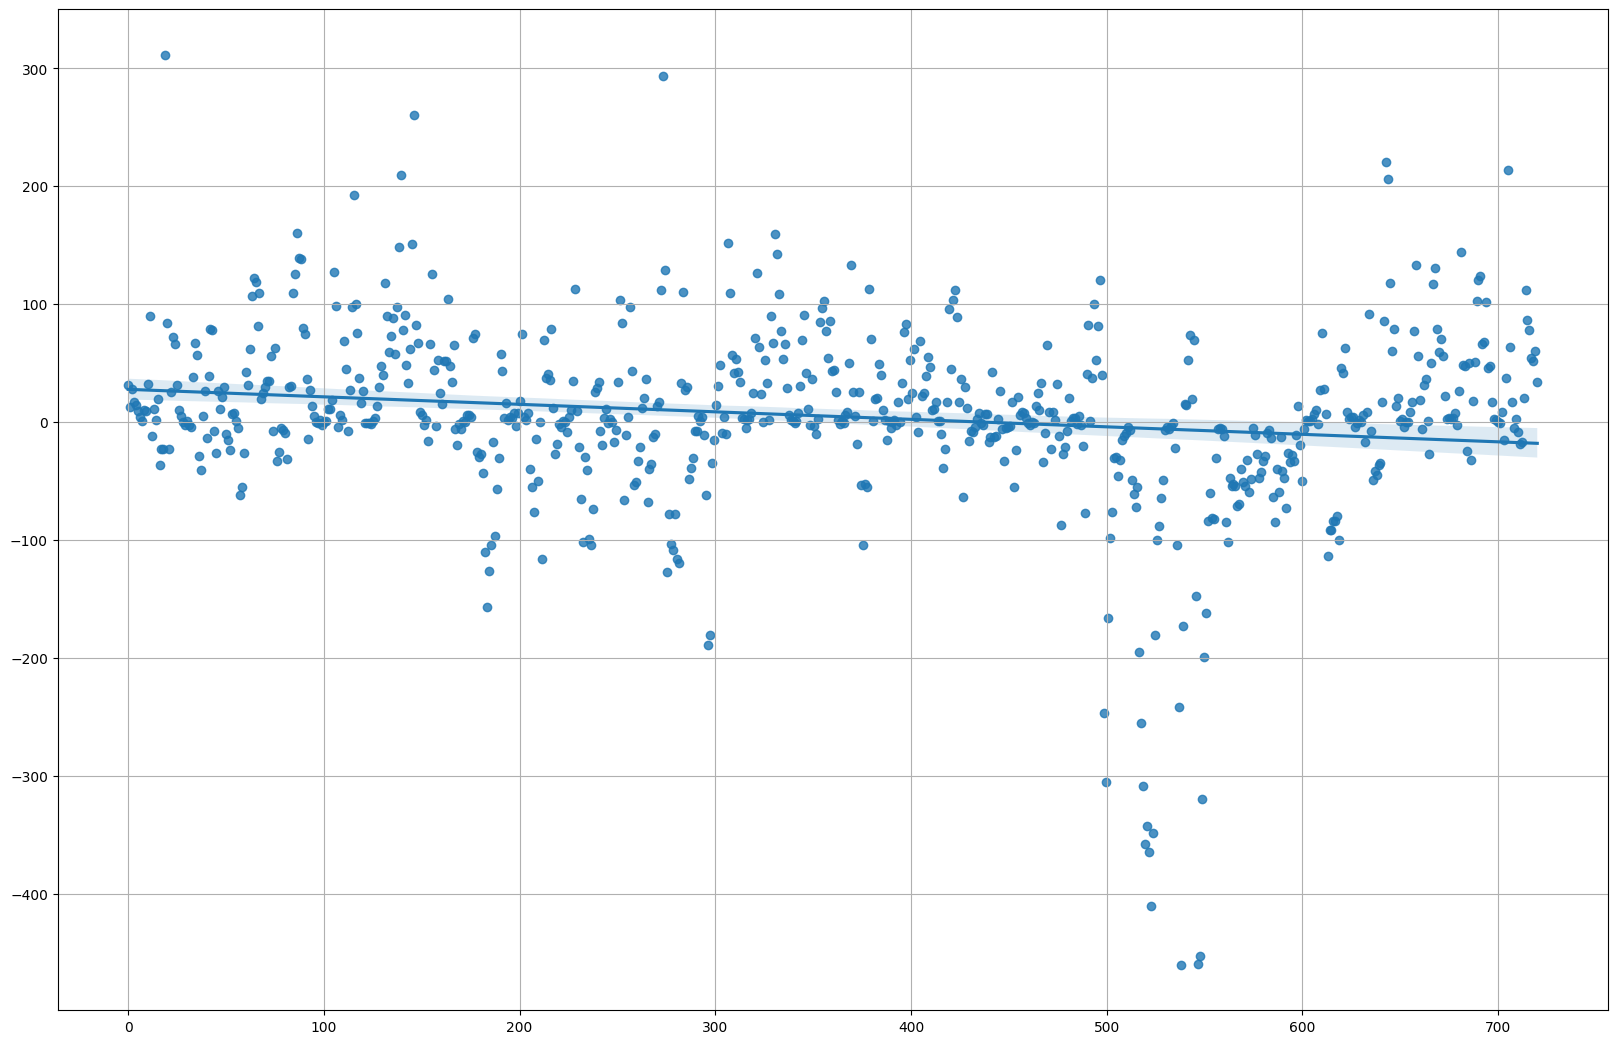

In [19]:
sns.regplot(x=xax, y=ae)

Random forest in contrast with xgboost tends to underestimate the count.

### Grid Search

In [20]:
xgb_params = {'max_depth': [i for i in range(2,9)],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
              'reg_lambda': [0.05, 0.1, 0.3]
             }
              
xgb_grid = GridSearchCV(XGBRegressor(n_jobs=-1),
                        param_grid=xgb_params,
                        cv = 10,
                        n_jobs=-1,
                        scoring='neg_mean_absolute_error',
                        return_train_score=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1}


In [21]:
-xgb_grid.best_score_

31.668068438859894

<module 'matplotlib.pyplot' from 'C:\\Users\\ggiam\\anaconda3\\envs\\py10\\lib\\site-packages\\matplotlib\\pyplot.py'>

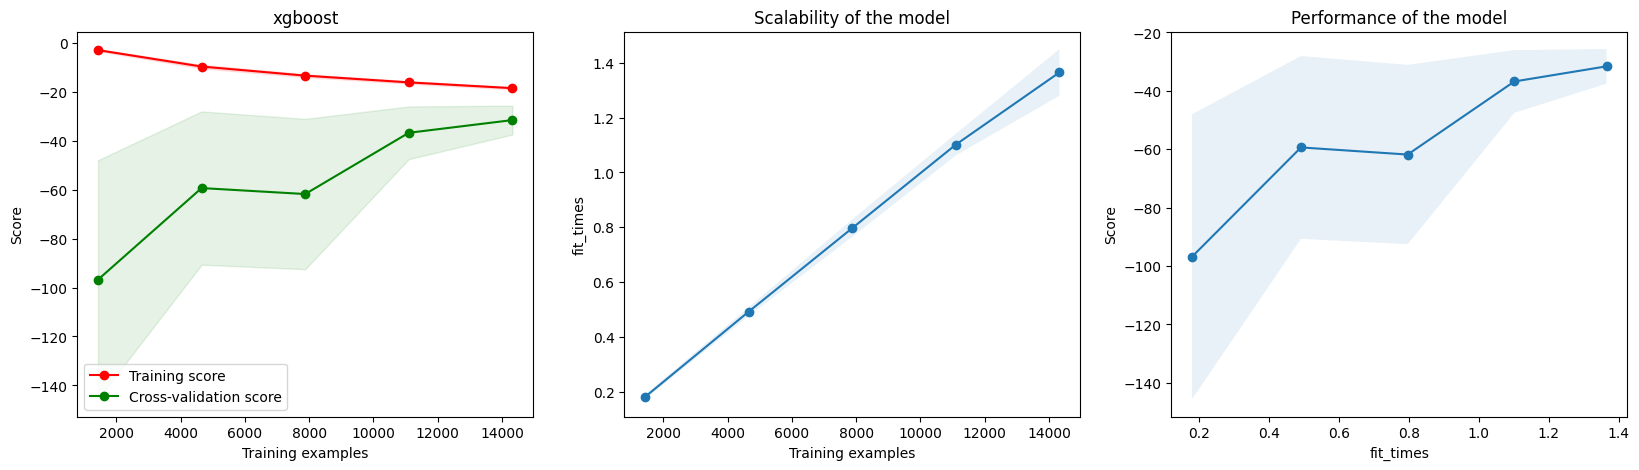

In [22]:
plot_learning_curve(xgb_grid.best_estimator_,'xgboost', X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')

Train MAE: 18.98131721385531 | Test MAE: 47.14980711903837
Train MAPE: 0.24929317378438756 | Test MAPE: 0.515515289386291
Train mean: 189.48520449833512 | Test mean: 212.40277777777777


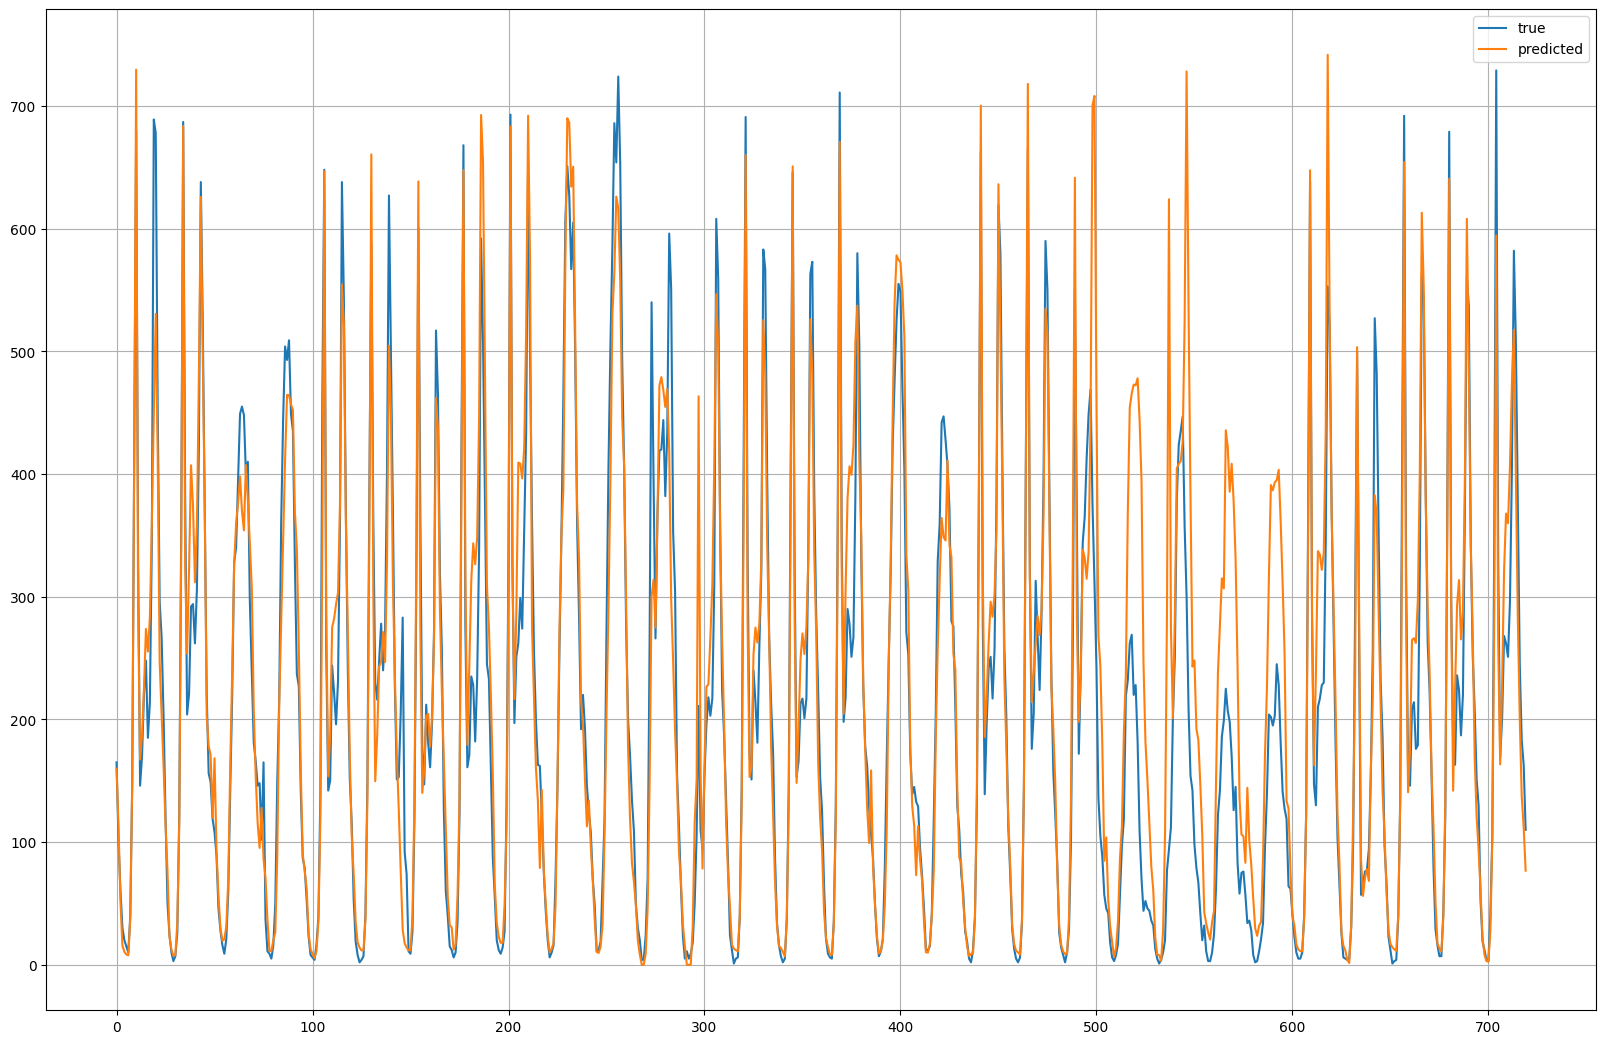

In [23]:
train_pred = xgb_grid.predict(X_train)
test_pred = xgb_grid.predict(X_test)

train_pred = np.where(train_pred < 0, 0, train_pred)
test_pred = np.where(test_pred < 0, 0, test_pred)

sns.lineplot(y_test, label='true')
sns.lineplot(test_pred, label='predicted')

print(f'Train MAE: {mean_absolute_error(y_train, train_pred)} | Test MAE: {mean_absolute_error(y_test, test_pred)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_pred)} | Test MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
print(f'Train mean: {y_train.mean()} | Test mean: {y_test.mean()}')

-16.84347740974691 74.99559071410927


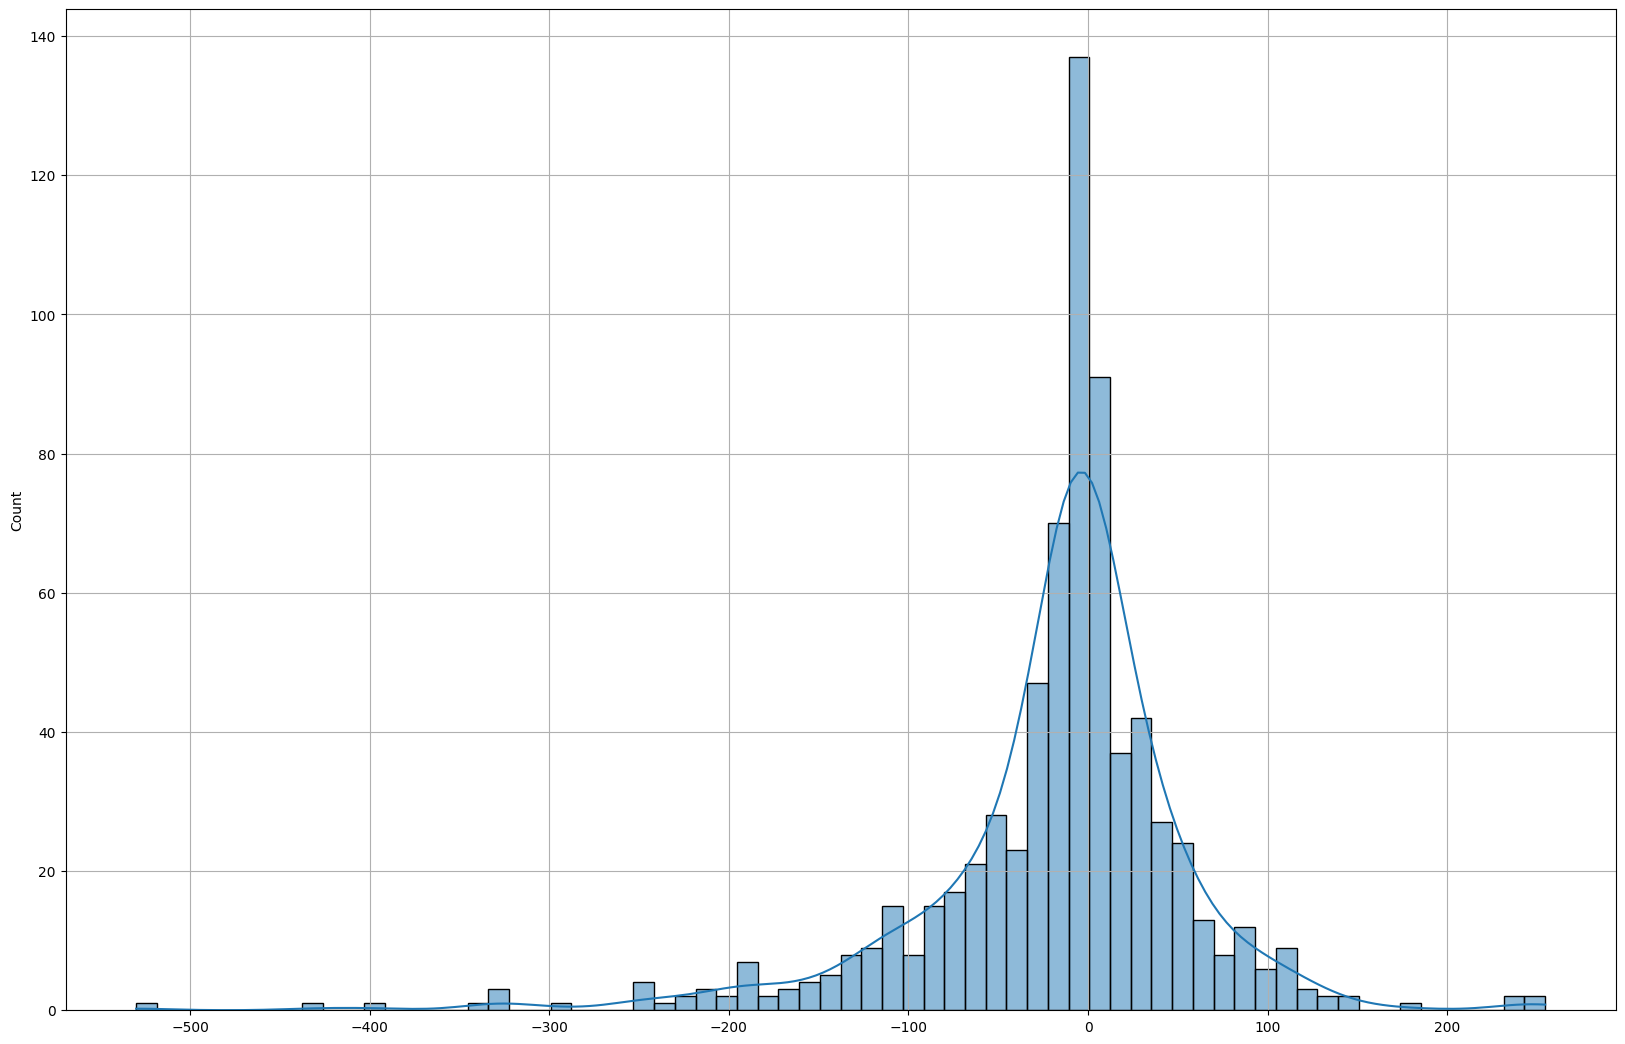

In [24]:
ae = y_test-test_pred
sns.histplot(ae, kde=True)
print(ae.mean(), ae.std())

<AxesSubplot: >

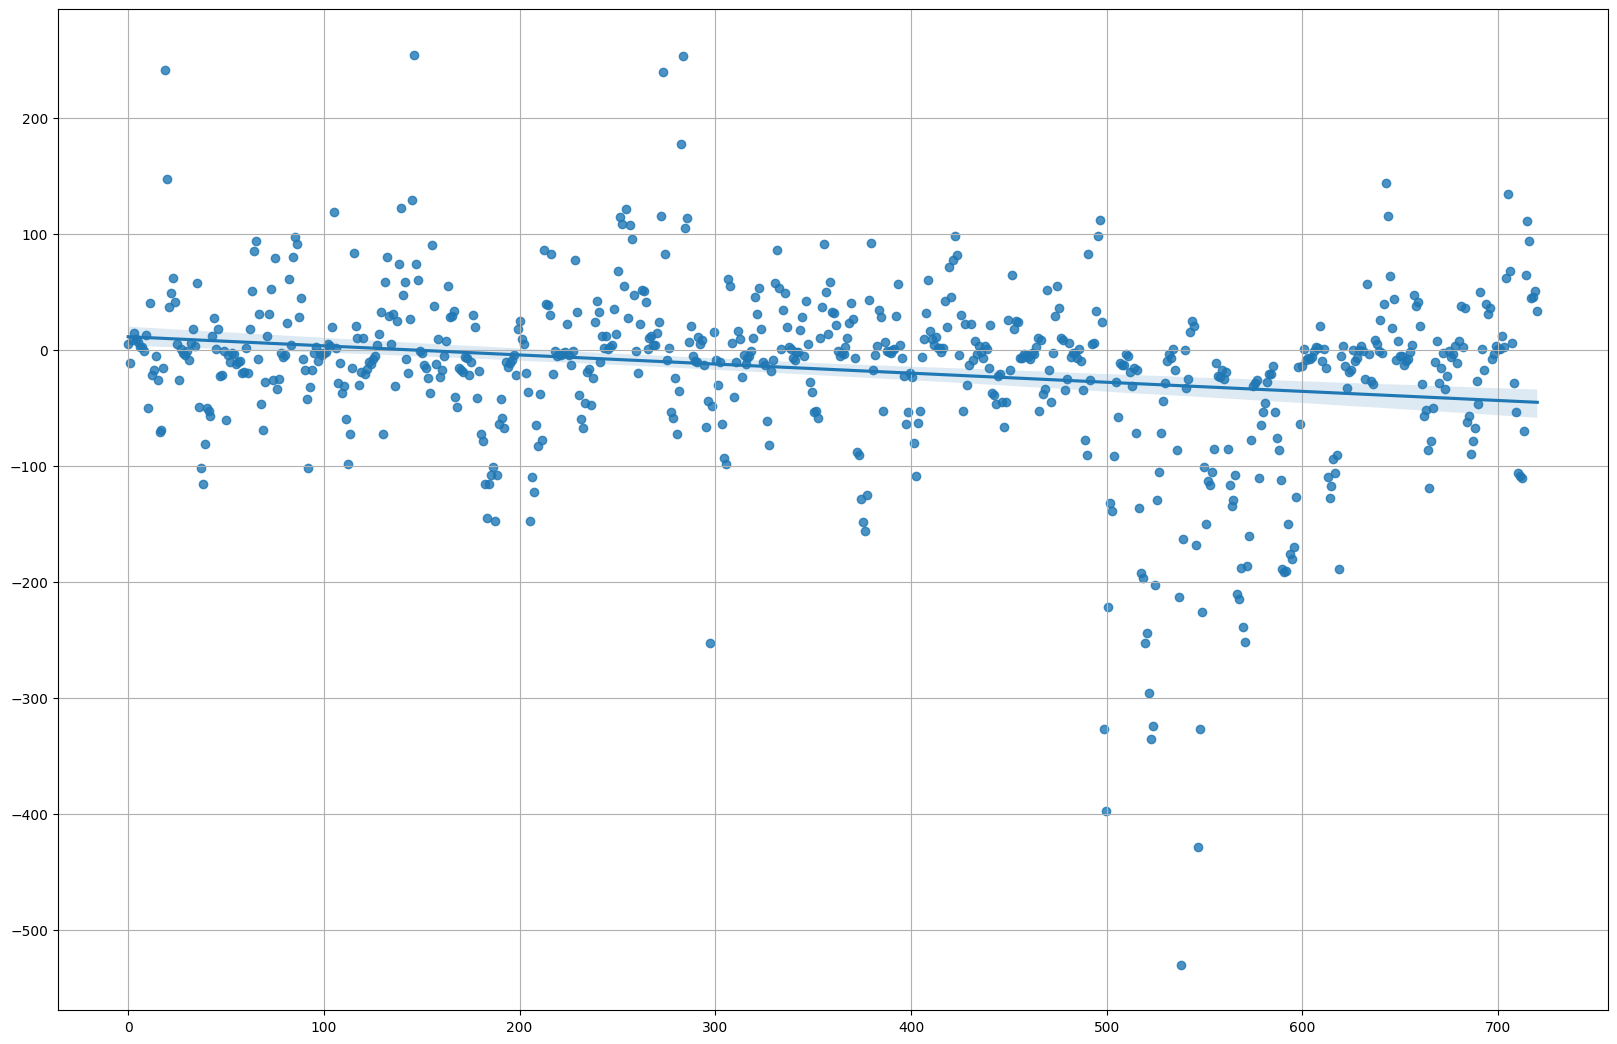

In [25]:
sns.regplot(x=xax, y=ae)

In [26]:
rf_params = {'max_depth': [i for i in range(6, 11)],
             'n_estimators': [i for i in range(70, 121, 10)],
             }
              

rf_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1),
                       param_grid=rf_params,
                       cv = 10,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error',
                       return_train_score=True)

rf_grid.fit(X_train, y_train)
best_params = rf_grid.best_params_
print(rf_grid.best_params_)

{'max_depth': 10, 'n_estimators': 90}


In [27]:
-rf_grid.best_score_

38.93343038329795

<module 'matplotlib.pyplot' from 'C:\\Users\\ggiam\\anaconda3\\envs\\py10\\lib\\site-packages\\matplotlib\\pyplot.py'>

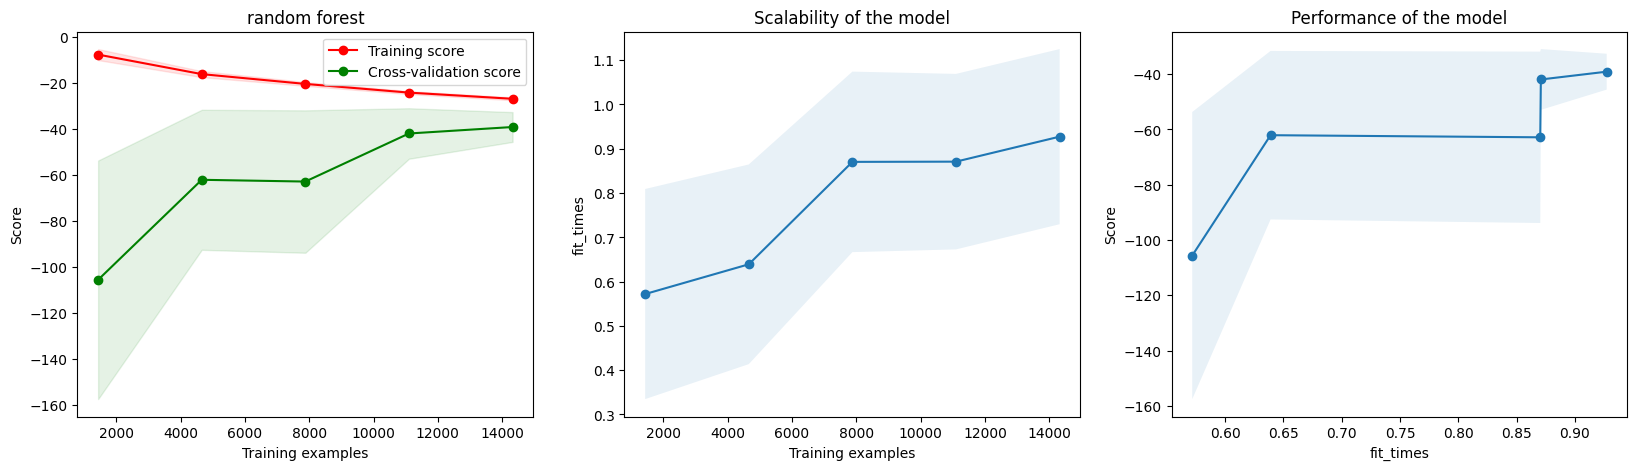

In [28]:
plot_learning_curve(rf_grid.best_estimator_,'random forest', X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')

Even if the range of grid search is at his limit increase the max_depth will lead to more overfitting, so we will leave like that.
<br>
By the way we reduced a lot overfit

Train MAE: 27.144813754633887 | Test MAE: 51.569400708396095
Train MAPE: 0.28898305622969944 | Test MAPE: 0.38169372725579537
Train mean: 189.48520449833512 | Test mean: 212.40277777777777


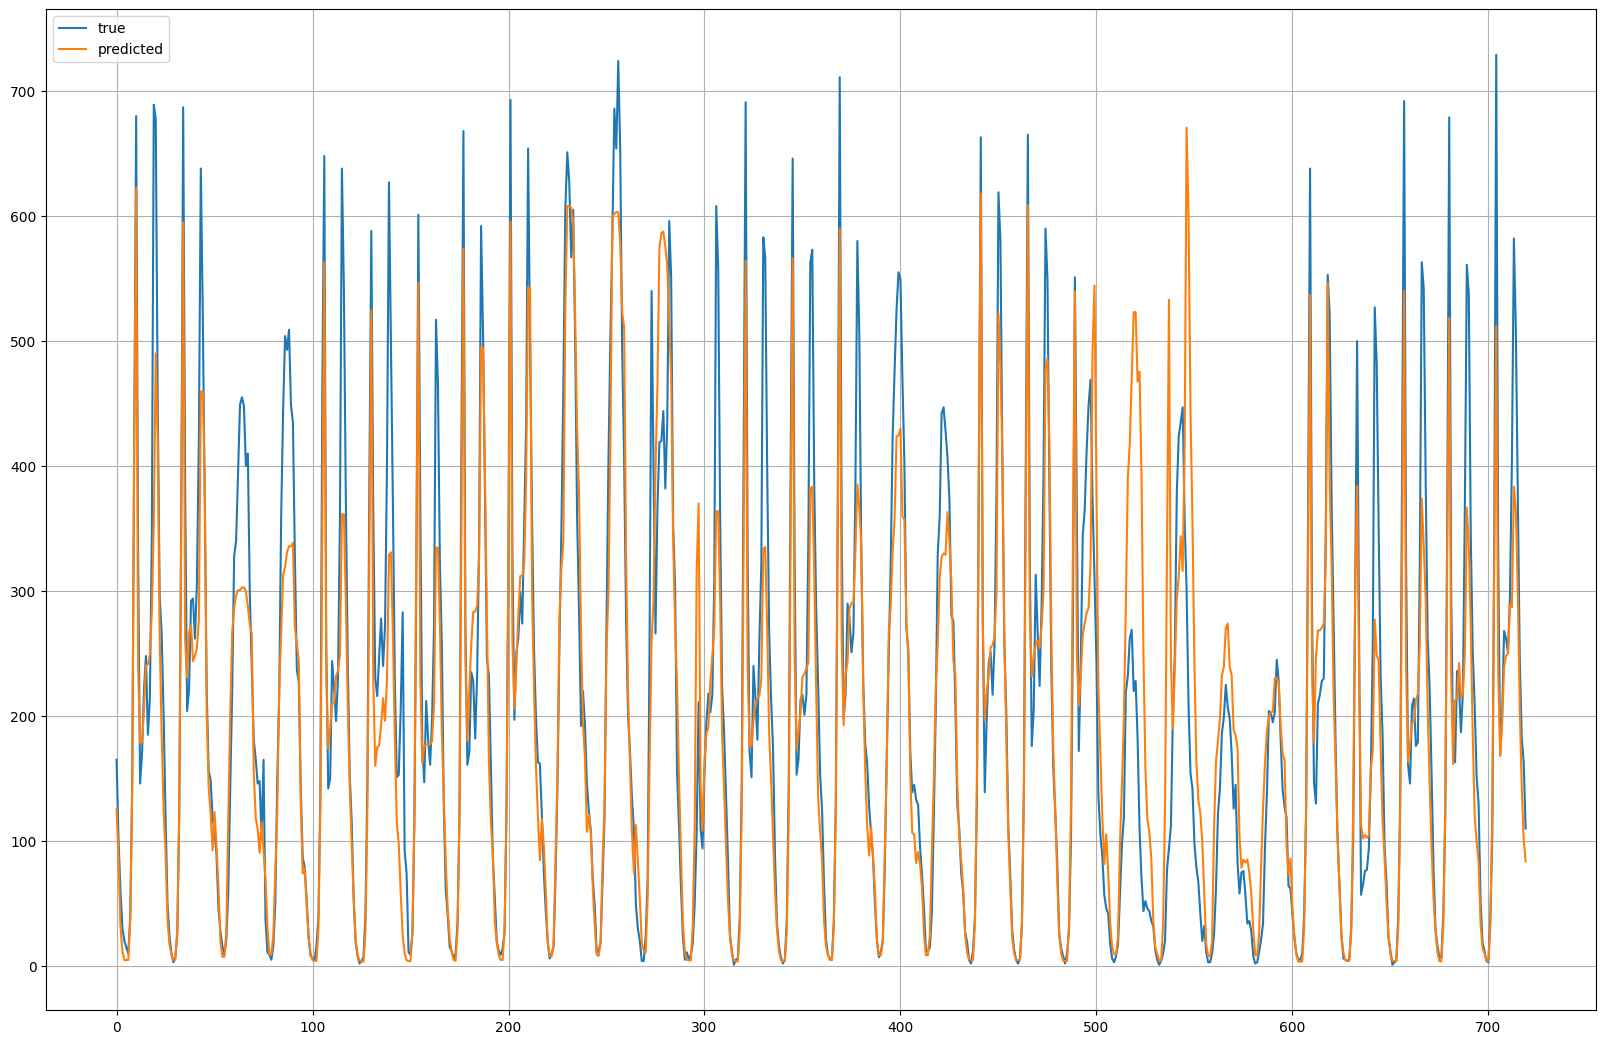

In [29]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

train_pred = np.where(train_pred < 0, 0, train_pred)
test_pred = np.where(test_pred < 0, 0, test_pred)

sns.lineplot(y_test, label='true')
sns.lineplot(test_pred, label='predicted')

print(f'Train MAE: {mean_absolute_error(y_train, train_pred)} | Test MAE: {mean_absolute_error(y_test, test_pred)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_pred)} | Test MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
print(f'Train mean: {y_train.mean()} | Test mean: {y_test.mean()}')

13.746276890849622 80.86207663821494


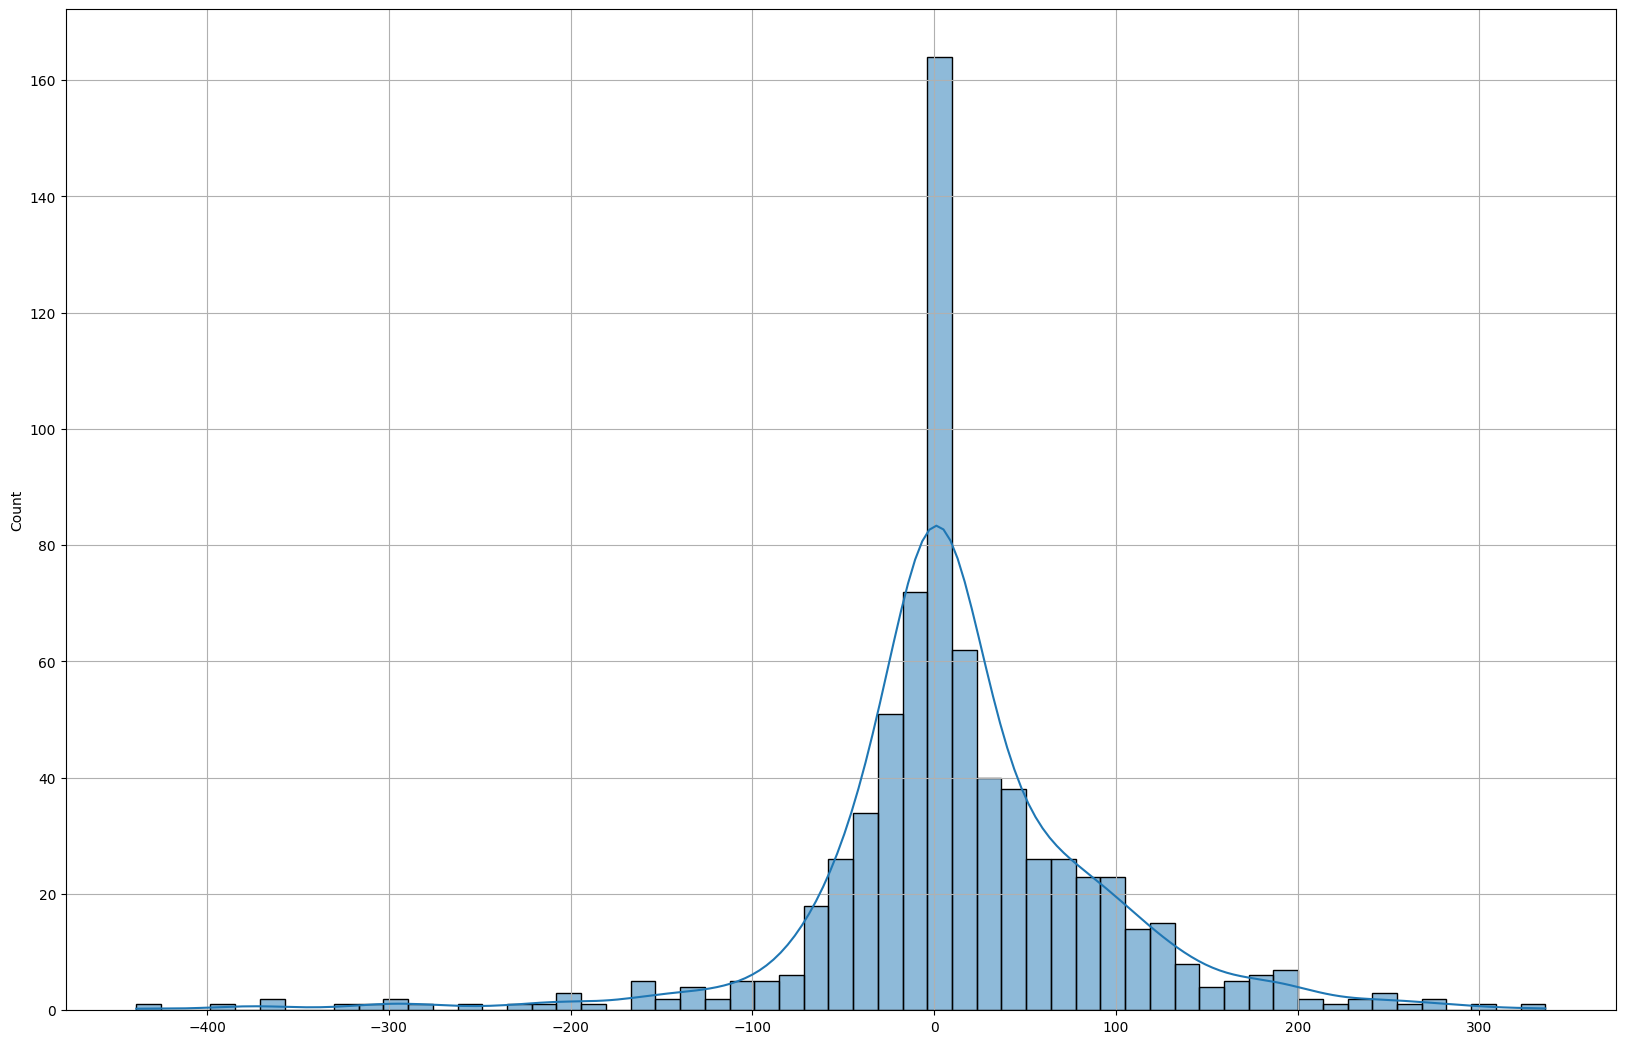

In [30]:
ae = y_test-test_pred
sns.histplot(ae, kde=True)
print(ae.mean(), ae.std())

<AxesSubplot: >

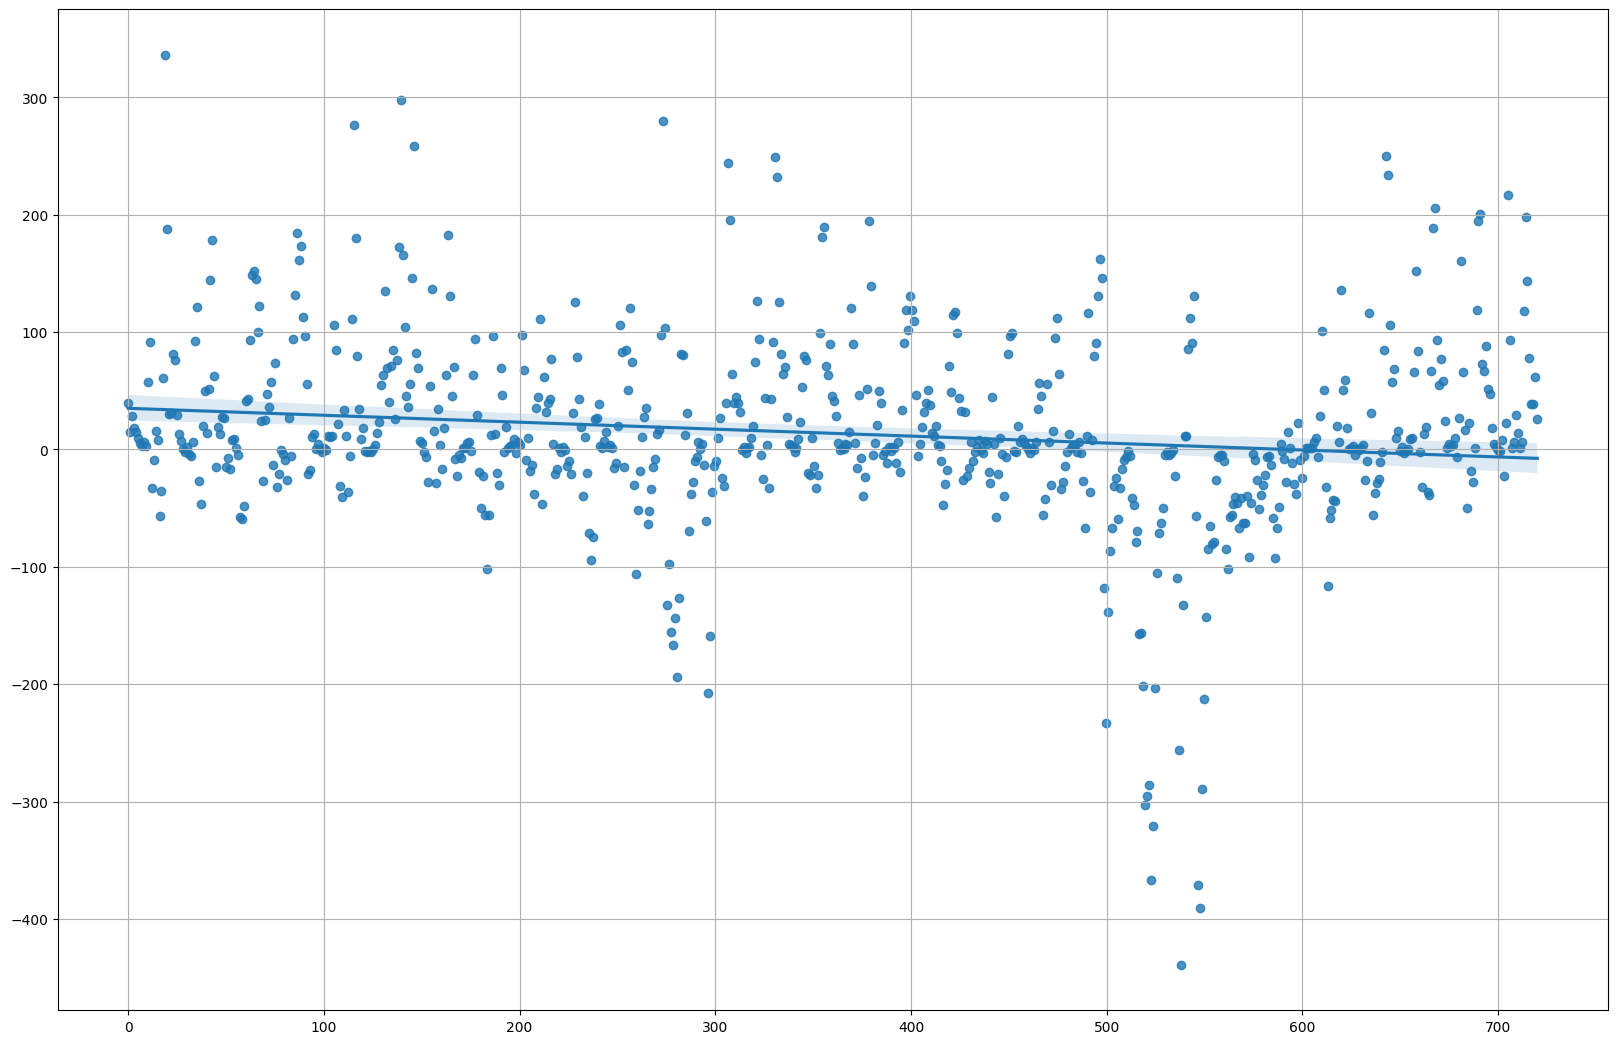

In [31]:
sns.regplot(x=xax, y=ae)

The best model so far is the Random Forest which performed good in both MAE and MAPE, with a MAE of around 51 and MAPE of 38%.
<br>
Now let's try to rearrange data to train our models like a time series.

## Time series model

As a first try we want to consider the count as a time series.
<br>
Let's reshape data considering the previous 12 hours features

In [32]:
X = []
y = []
hours = 12

for s in range(hours, data2.shape[0]):
    X.append(data2.values[s-hours:s, :-1].flatten())
    y.append(data2.values[s, -1])
    
X = np.array(X)
y = np.array(y)

#scale data and splitting the lasto 300 hours

X_train = X[:-720,:]
X_test = X[-720:,:]
y_train = y[:-720]
y_test = y[-720:]

So far the Random Forest has performed slightly better, so for this next step we will consider only the forest (even if it is slower to train)

In [33]:
X_train.shape

(15905, 120)

Dataframe is big now, let's pray for the CPU.
<br>
At first we try a base model.

<module 'matplotlib.pyplot' from 'C:\\Users\\ggiam\\anaconda3\\envs\\py10\\lib\\site-packages\\matplotlib\\pyplot.py'>

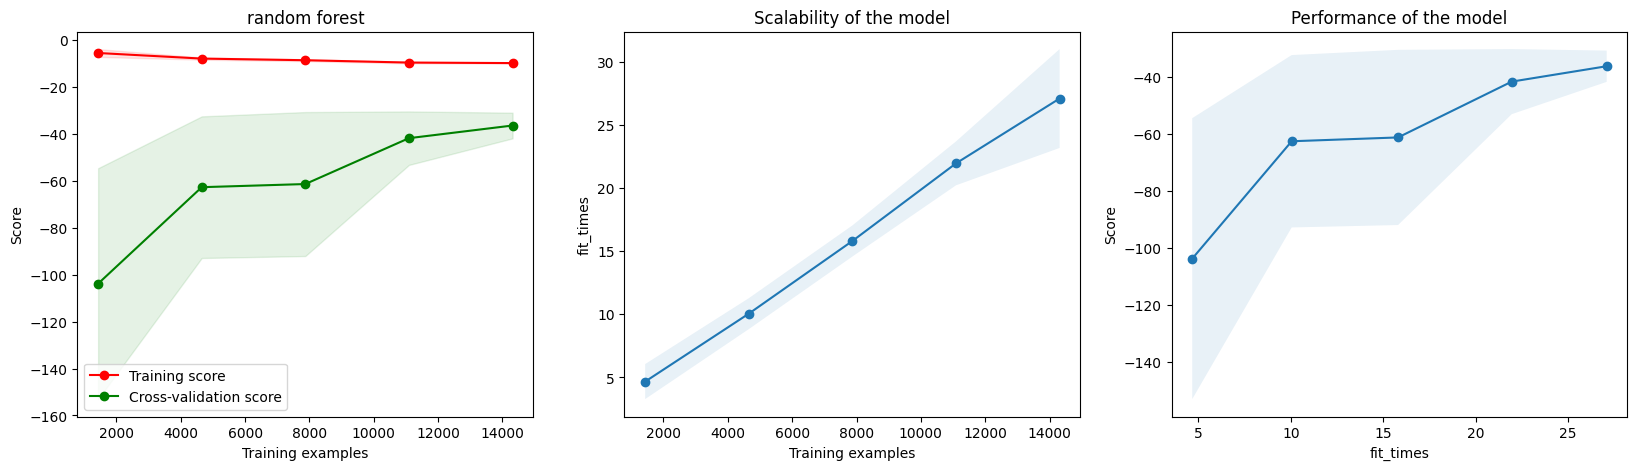

In [34]:
rf_ts = RandomForestRegressor(n_jobs=-1)
plot_learning_curve(rf_ts,'random forest', X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')

Train MAE: 9.646250235774914 | Test MAE: 52.23712499999999
Train MAPE: 0.12618724693499797 | Test MAPE: 0.3896723223132918
Train mean: 189.61420936812323 | Test mean: 212.40277777777777


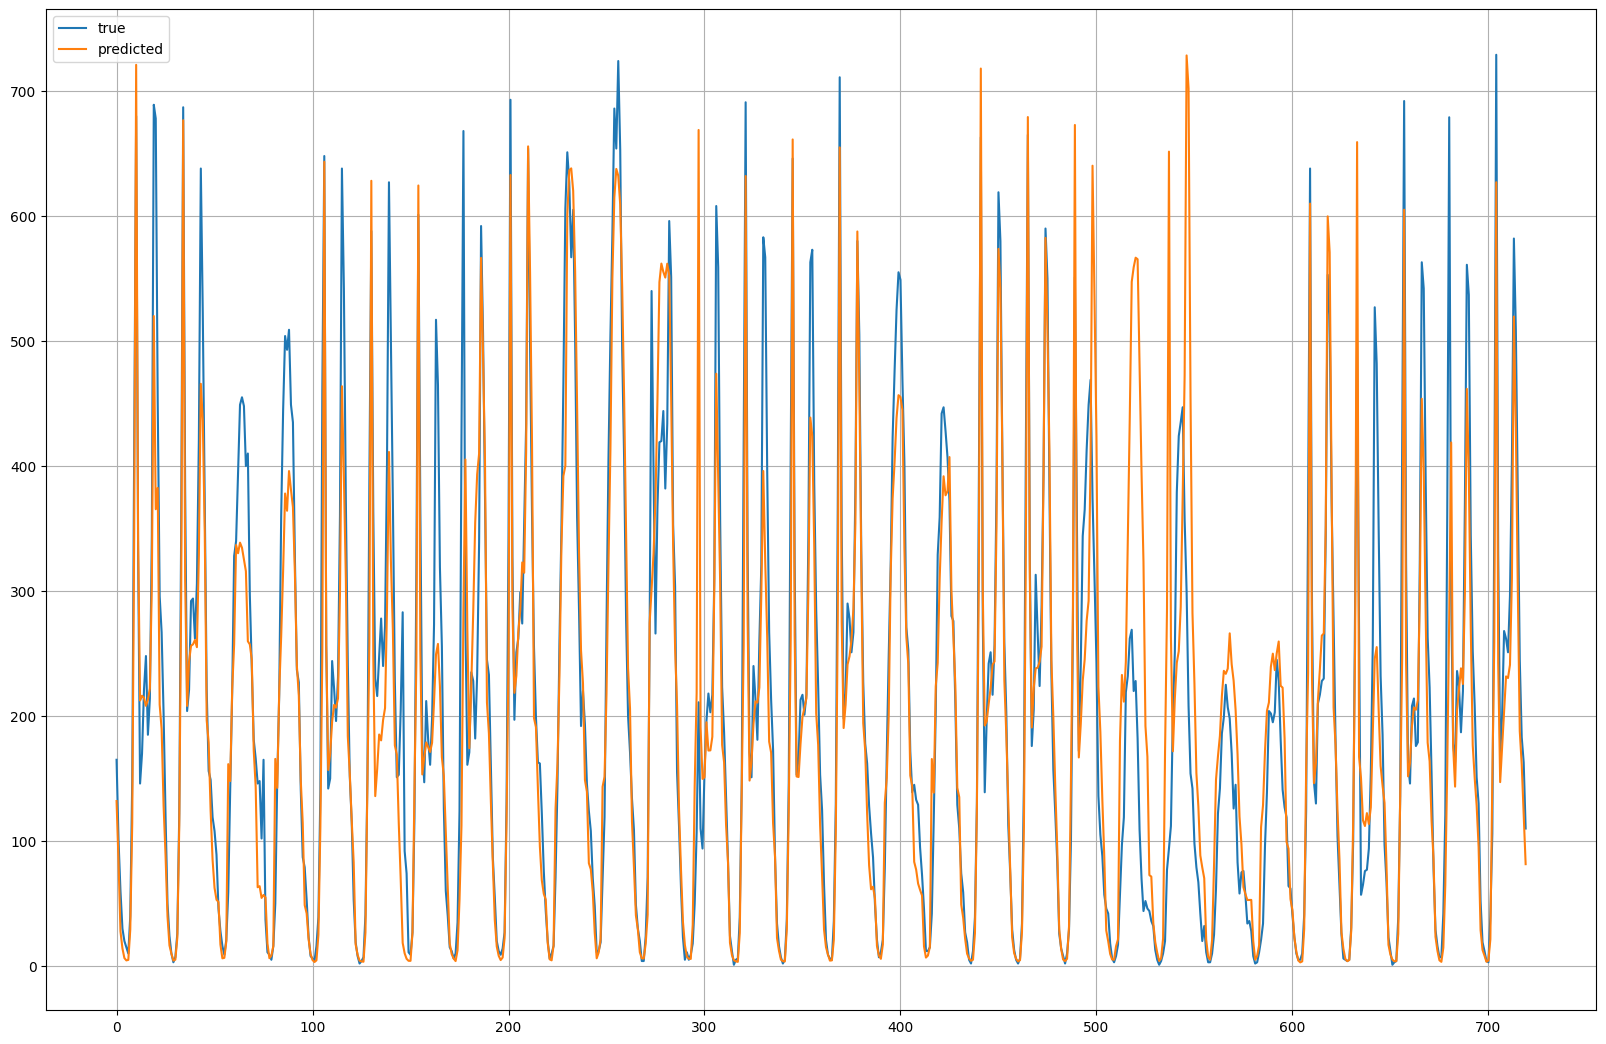

In [35]:
rf_ts.fit(X_train, y_train)

train_pred = rf_ts.predict(X_train)
test_pred = rf_ts.predict(X_test)

train_pred = np.where(train_pred < 0, 0, train_pred)
test_pred = np.where(test_pred < 0, 0, test_pred)

sns.lineplot(y_test, label='true')
sns.lineplot(test_pred, label='predicted')

print(f'Train MAE: {mean_absolute_error(y_train, train_pred)} | Test MAE: {mean_absolute_error(y_test, test_pred)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_pred)} | Test MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
print(f'Train mean: {y_train.mean()} | Test mean: {y_test.mean()}')

Let's see if it is better with a Gridsearch

In [36]:
rf_params = {'max_depth': [i for i in range(5,10)],
             'n_estimators': [i for i in range(70, 121, 10)],
             }
              
rf_grid_ts = GridSearchCV(RandomForestRegressor(n_jobs=-1),
                        param_grid=rf_params,
                        cv = TimeSeriesSplit(10),
                        n_jobs=-1,
                        scoring='neg_mean_absolute_error',
                        return_train_score=True)

rf_grid_ts.fit(X_train, y_train)

print(rf_grid_ts.best_params_)

{'max_depth': 9, 'n_estimators': 110}


In [37]:
-rf_grid_ts.best_score_

51.07839210443762

<module 'matplotlib.pyplot' from 'C:\\Users\\ggiam\\anaconda3\\envs\\py10\\lib\\site-packages\\matplotlib\\pyplot.py'>

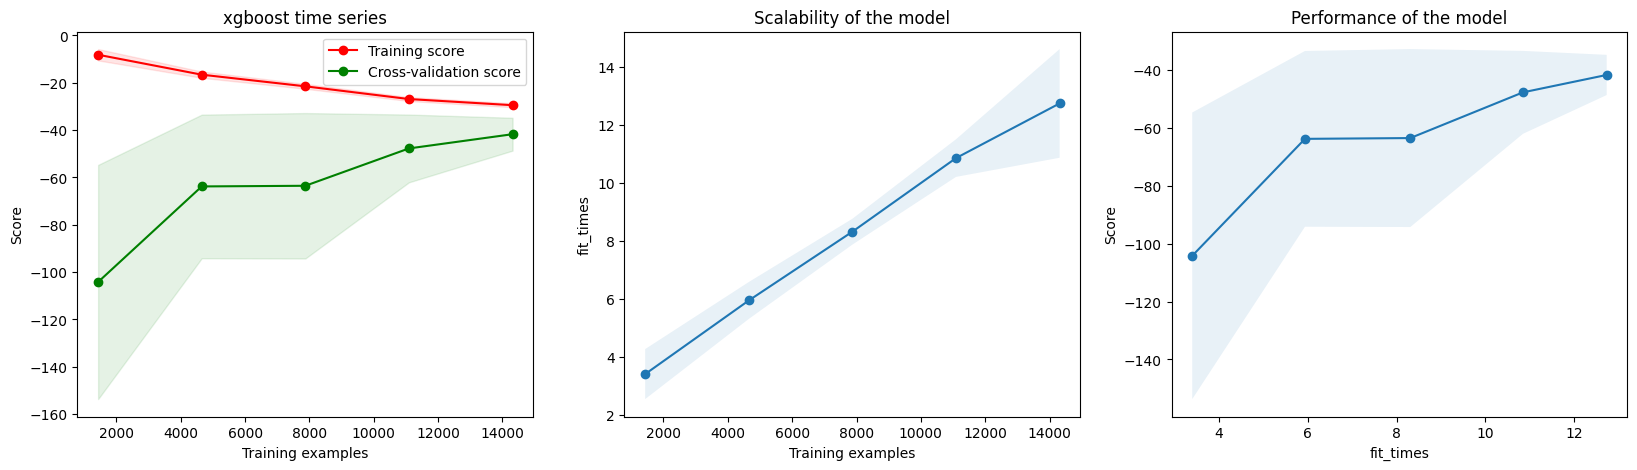

In [38]:
plot_learning_curve(rf_grid_ts.best_estimator_,'random forest time series', X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')

Train MAE: 30.116816685514426 | Test MAE: 61.73586266628742
Train MAPE: 0.349435742838172 | Test MAPE: 0.4177644148315919
Train mean: 189.61420936812323 | Test mean: 212.40277777777777


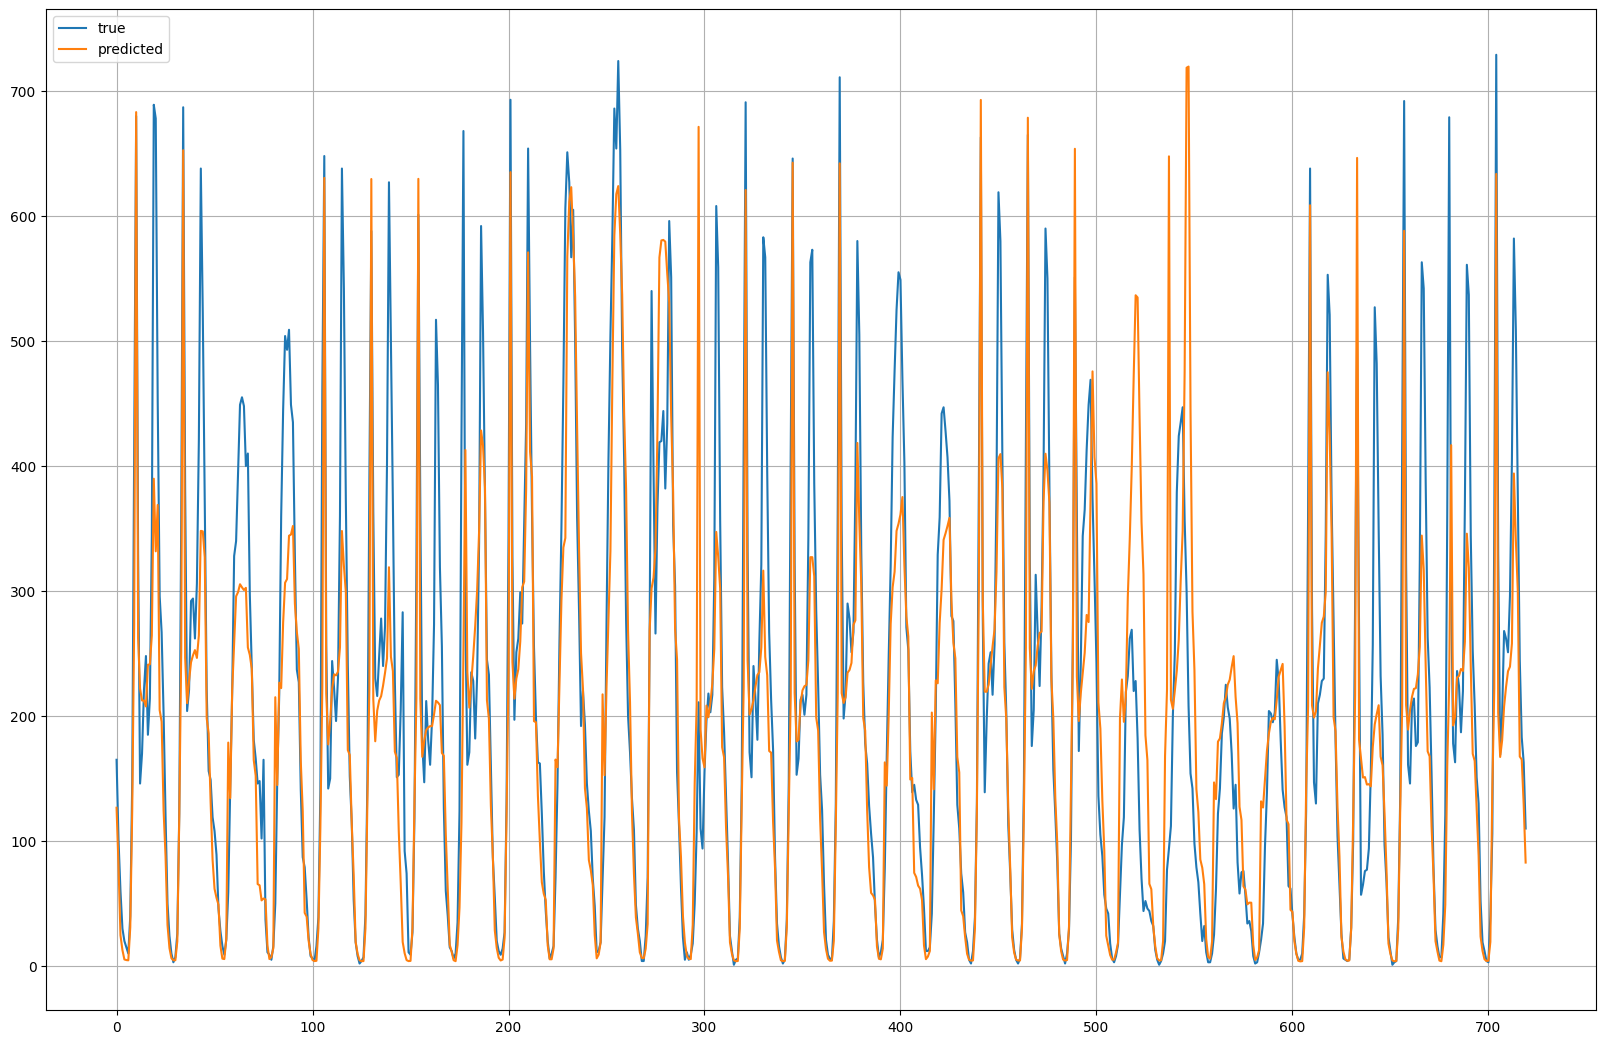

In [39]:
train_pred = rf_grid_ts.predict(X_train)
test_pred = rf_grid_ts.predict(X_test)

train_pred = np.where(train_pred < 0, 0, train_pred)
test_pred = np.where(test_pred < 0, 0, test_pred)

sns.lineplot(y_test, label='true')
sns.lineplot(test_pred, label='predicted')

print(f'Train MAE: {mean_absolute_error(y_train, train_pred)} | Test MAE: {mean_absolute_error(y_test, test_pred)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_pred)} | Test MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
print(f'Train mean: {y_train.mean()} | Test mean: {y_test.mean()}')

20.35218480267258 96.99484207428227


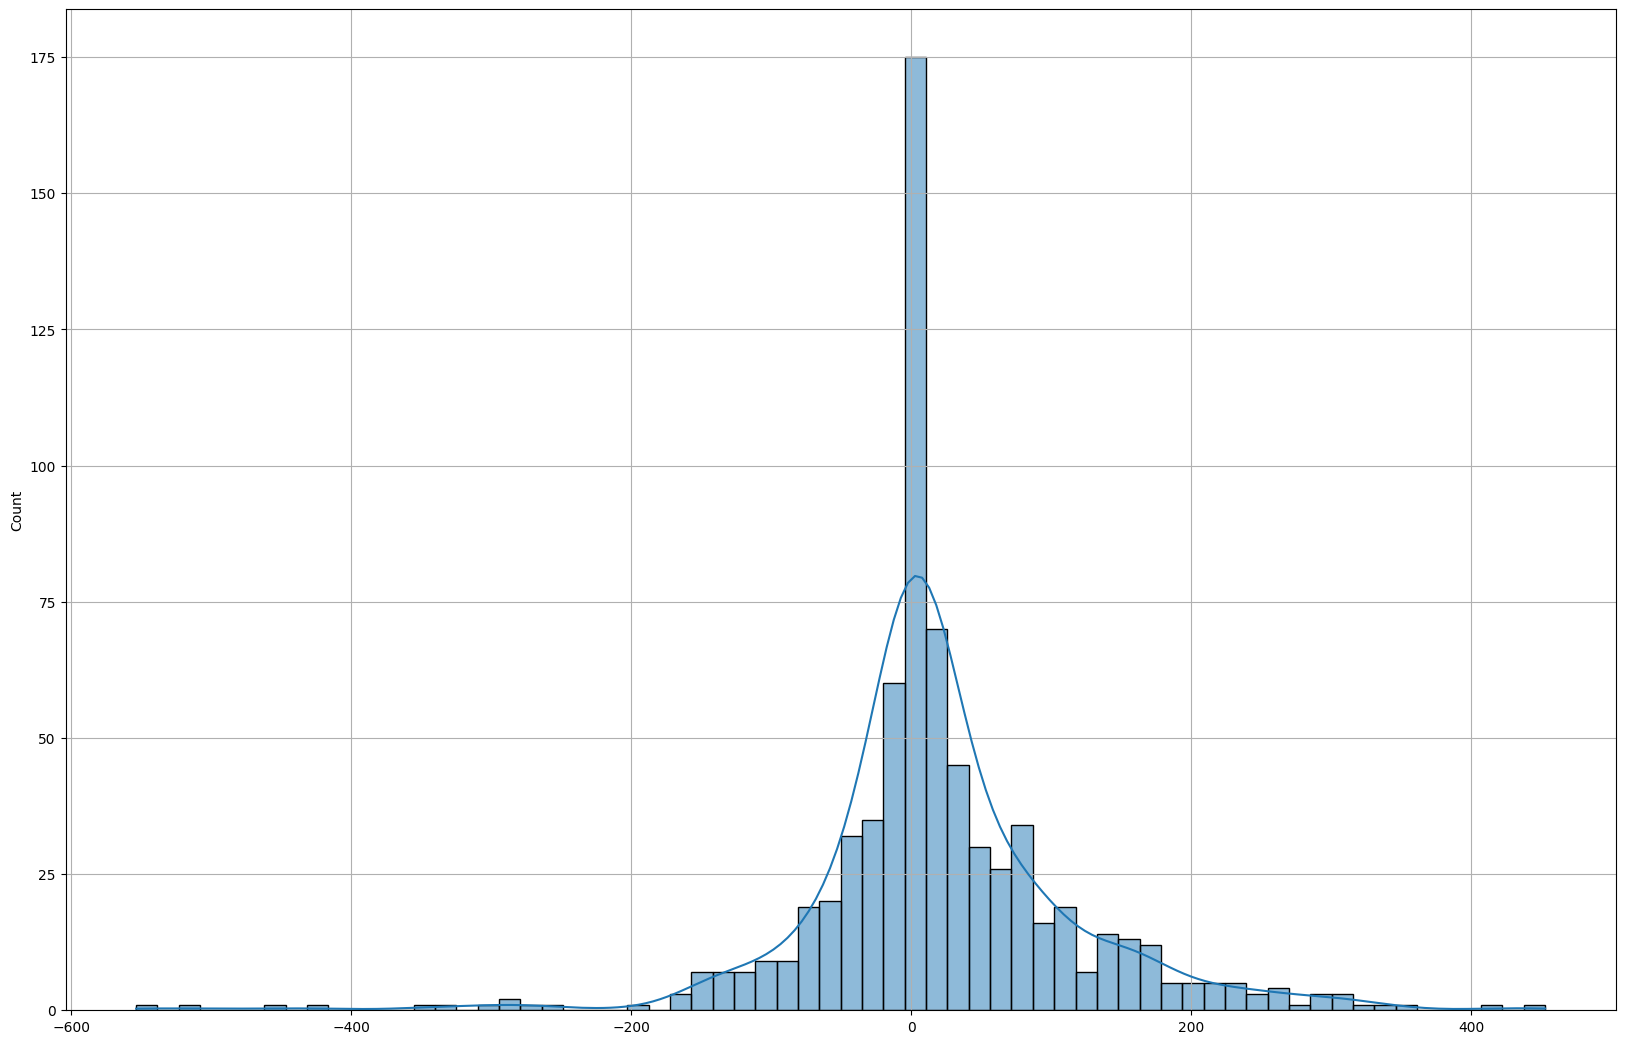

In [40]:
ae = y_test-test_pred
sns.histplot(ae, kde=True)
print(ae.mean(), ae.std())

<AxesSubplot: >

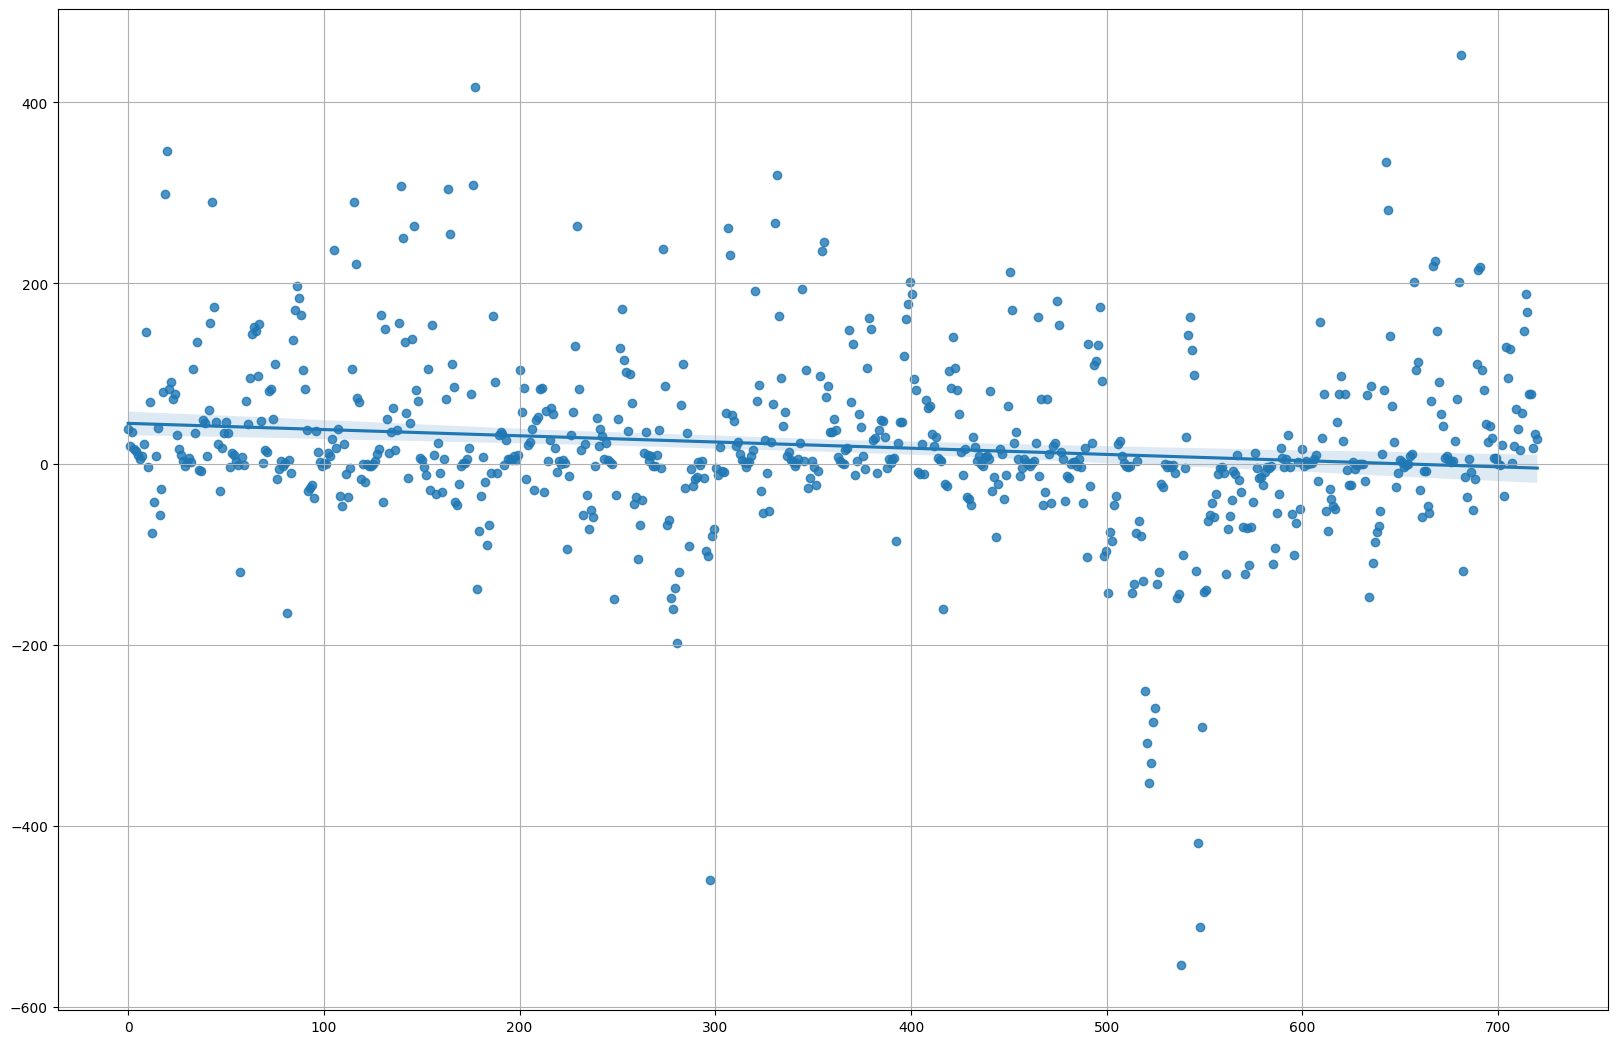

In [41]:
sns.regplot(x=xax, y=ae)

The best model so far is the Random Forest non time series.
<br>
Now let's build the pipeline for the process

# Pipeline and test set

The steps made where just drop some columns and scale the categorical ones.
<br> 
Let's build a transformer that does that

In [42]:
class Dropper(BaseEstimator, TransformerMixin):
    
    """
    Drop specified columns from the dataframe
    """
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data = X
        data = data.drop(self.cols, axis=1)
        
        return data

Now we are ready for the full pipeline

In [43]:
transformer = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), [1,2,4,6])],
                                remainder='passthrough')

drop_cols = ['instant', 'dteday', 'atemp', 'season']

pipe = Pipeline(steps=[('dropper', Dropper(drop_cols)),
                       ('scaler', transformer),
                       ('model', RandomForestRegressor(**best_params))]
               )
            
pipe.fit(data.iloc[:,:-1], data.iloc[:,-1])

Pipeline(steps=[('dropper',
                 Dropper(cols=['instant', 'dteday', 'atemp', 'season'])),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  [1, 2, 4, 6])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=90))])

In [44]:
test = pd.read_csv('./data/test.csv')
pp = pipe.predict(test)

<AxesSubplot: >

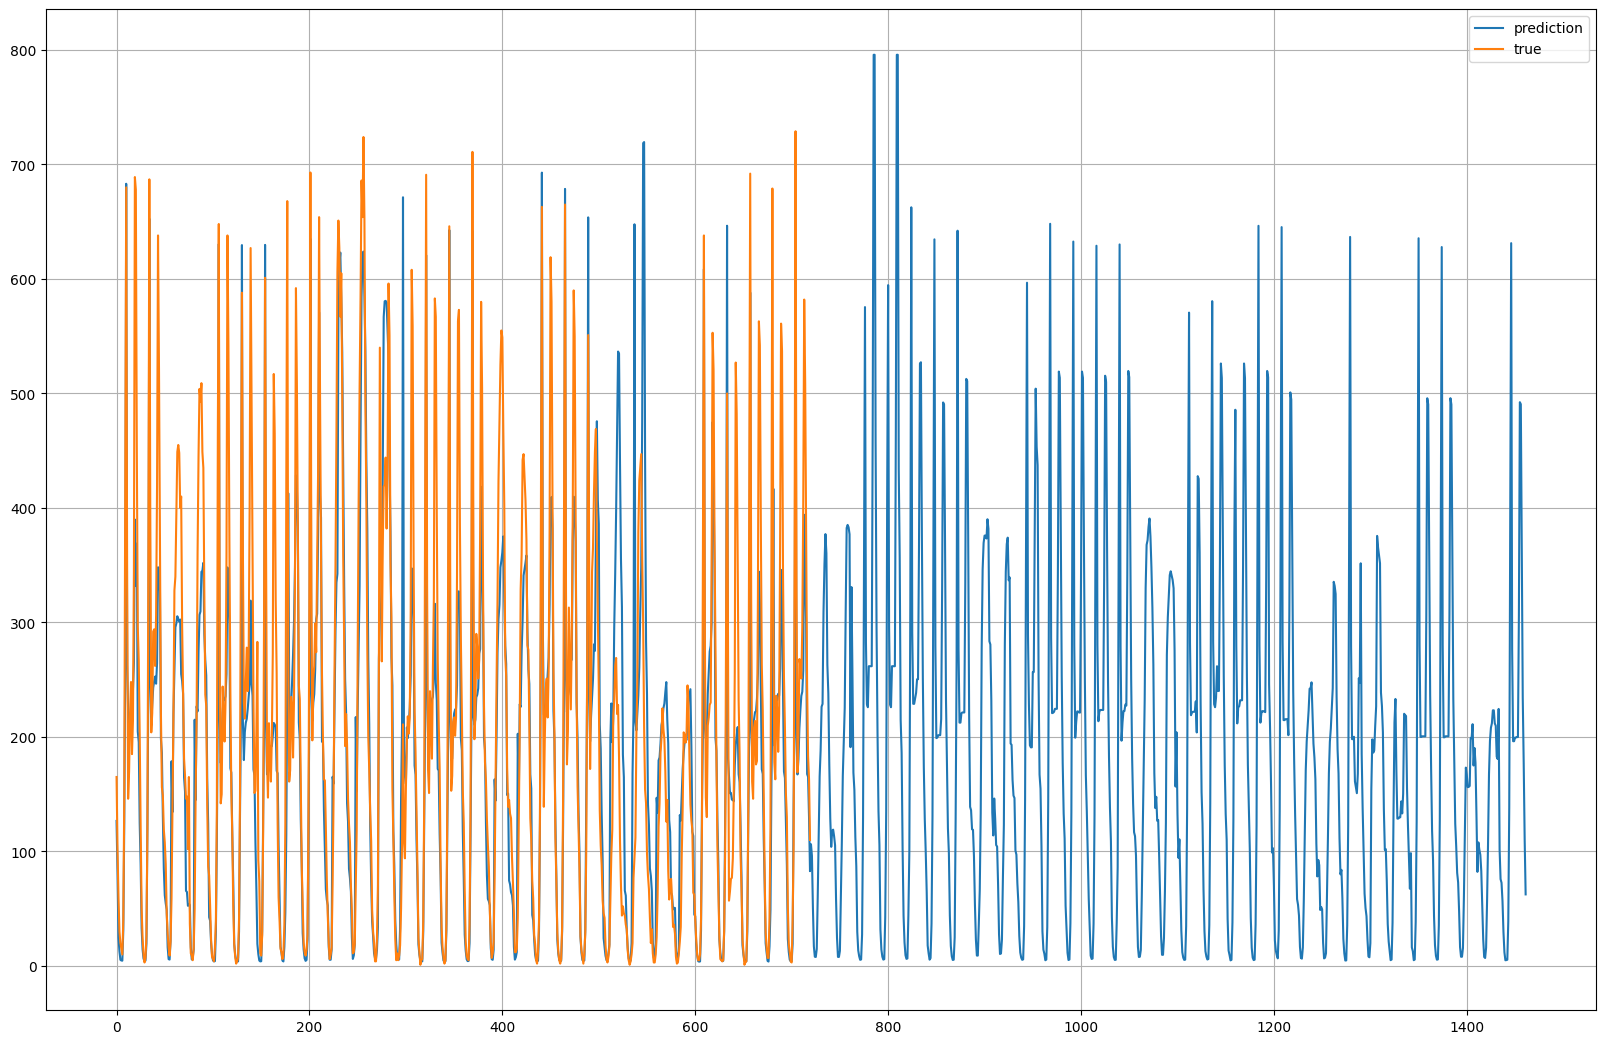

In [45]:
tot = np.append(test_pred, pp) 
sns.lineplot(tot, label='prediction')
sns.lineplot(y_test, label='true')

The prediction seems at least coherent.
<br>
Now we'll save the model and the rsults csv.

In [46]:
import joblib
joblib.dump(pipe, 'Nicolò_Giammaria_model.joblib')

['Nicolò_Giammaria_model.joblib']

In [47]:
result_csv = test.loc[:, ['dteday','hr']]
result_csv.columns = ['date', 'hour']
result_csv['count'] = np.round(pp,0)

In [48]:
result_csv

date  hour  count
0    2012-12-01     0  106.0
1    2012-12-01     1   96.0
2    2012-12-01     2   51.0
3    2012-12-01     3   17.0
4    2012-12-01     4    8.0
..          ...   ...    ...
737  2012-12-31    19  369.0
738  2012-12-31    20  234.0
739  2012-12-31    21  176.0
740  2012-12-31    22  110.0
741  2012-12-31    23   62.0

[742 rows x 3 columns]

Let's set negative values to 0

In [49]:
result_csv.loc[result_csv['count'] < 0, 'count'] = 0

In [50]:
result_csv.head(15)

date  hour  count
0   2012-12-01     0  106.0
1   2012-12-01     1   96.0
2   2012-12-01     2   51.0
3   2012-12-01     3   17.0
4   2012-12-01     4    8.0
5   2012-12-01     5    8.0
6   2012-12-01     6   15.0
7   2012-12-01     7   60.0
8   2012-12-01     8  116.0
9   2012-12-01     9  166.0
10  2012-12-01    10  188.0
11  2012-12-01    11  226.0
12  2012-12-01    12  229.0
13  2012-12-01    13  309.0
14  2012-12-01    14  351.0

Just to be sure, let's plot again

<AxesSubplot: >

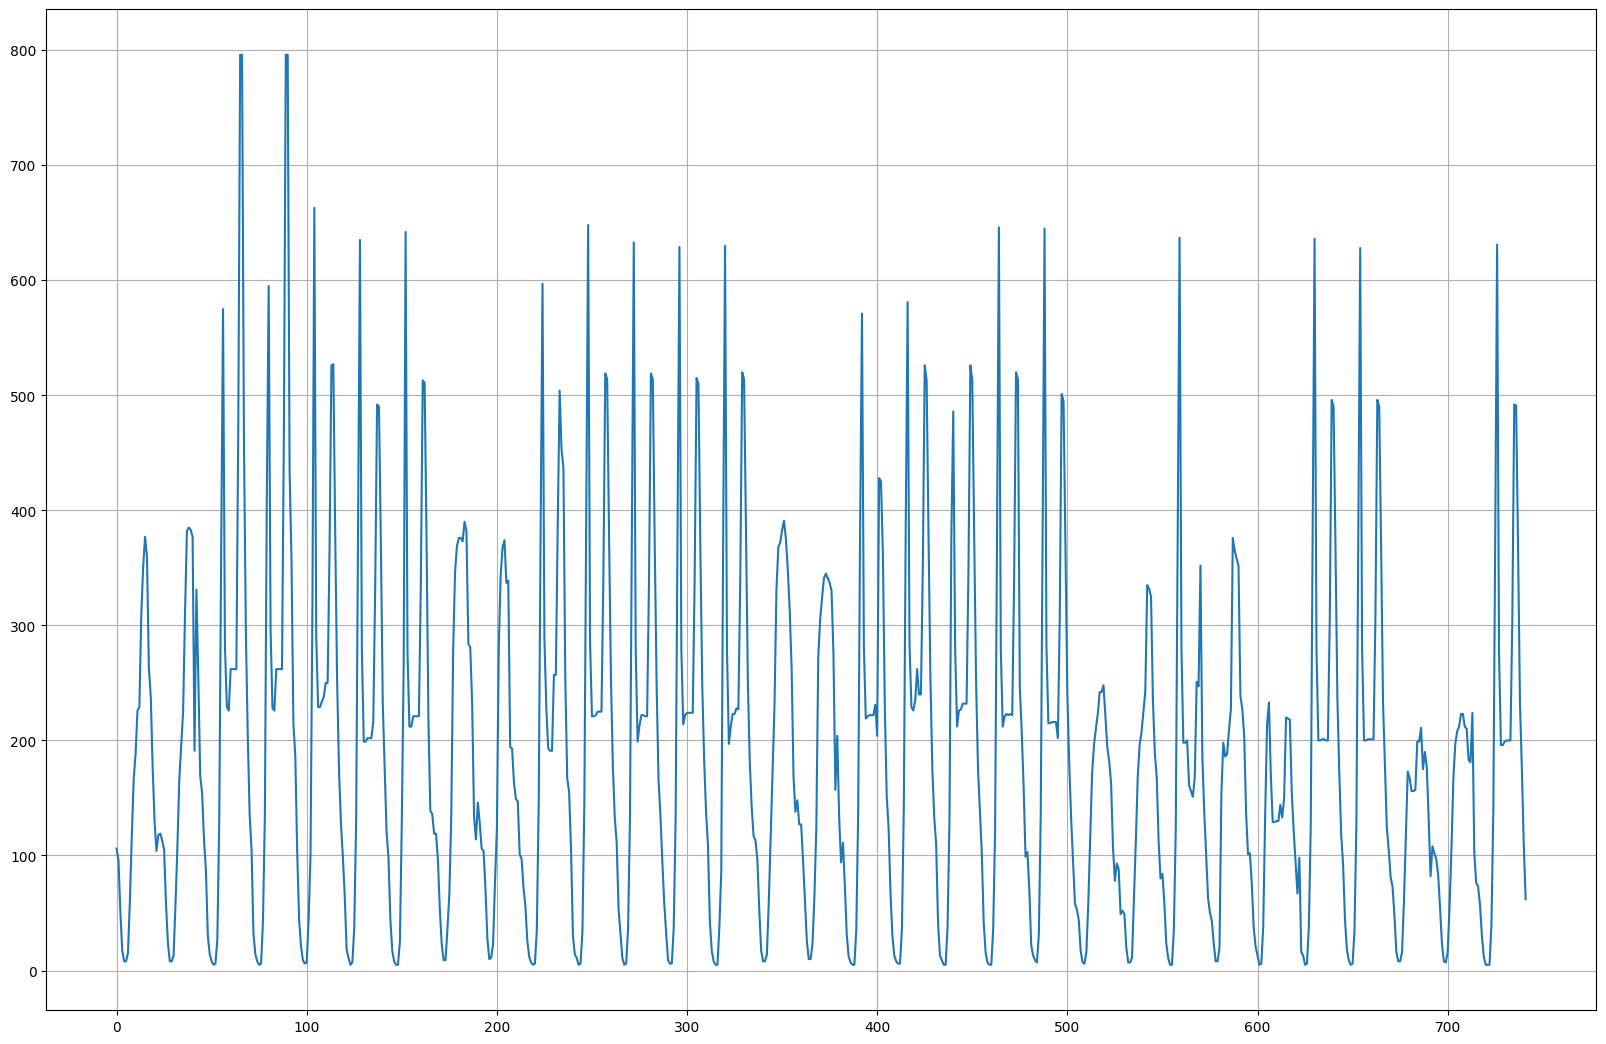

In [51]:
result_csv['count'].plot()

In [52]:
result_csv.to_csv('Nicolò_Giammaria_results.csv', index=False)